In [95]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from typing import Dict, Tuple, List
from google.colab import drive
import pathlib
import os
import zipfile
import re
import pickle
from sklearn.preprocessing import LabelEncoder
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import chi2
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, f1_score, accuracy_score, confusion_matrix
from sklearn.neighbors import KNeighborsClassifier
from xgboost import XGBClassifier
from catboost import CatBoostClassifier
import xgboost

In [96]:
xgboost.__version__

'2.0.3'

In [1]:
! pip install catboost

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 98.5/98.5 MB 9.4 MB/s eta 0:00:00


### The entire project is done on google colab, so we need to mount our drive to our colab environment

In [3]:
drive.mount("/content/drive")

Mounted at /content/drive


In [4]:
path = "/content/drive/MyDrive/Kaggle/obesity_prediction"
os.chdir(path)
os.listdir()
# We change the path to our current dir

['train.csv.zip',
 'train',
 'catboost_info',
 'test_file.csv',
 'xgboost.pkl',
 'encodings.csv',
 'Obesity Prediction.ipynb']

In [5]:
# Our folder is in a zip format so we need to unzip it

with zipfile.ZipFile("train.csv.zip", "r") as zip_ref:
  if not os.path.exists("train"):
    print("Creating a new directory, writing csv file to train folder")
    zip_ref.extractall("train")
  else:
    print("Folder for train, already exists, writing data to existing folder")

Folder for train, already exists, writing data to existing folder


In [6]:
train_path = path + "/train/train.csv"

data = pd.read_csv(train_path)

In [7]:
data.head()

,id,Gender,Age,Height,Weight,family_history_with_overweight,FAVC,FCVC,NCP,CAEC,SMOKE,CH2O,SCC,FAF,TUE,CALC,MTRANS,NObeyesdad
0,0,Male,24.443011,1.699998,81.669950,yes,yes,2.000000,2.983297,Sometimes,no,2.763573,no,0.000000,0.976473,Sometimes,Public_Transportation,Overweight_Level_II
1,1,Female,18.000000,1.560000,57.000000,yes,yes,2.000000,3.000000,Frequently,no,2.000000,no,1.000000,1.000000,no,Automobile,Normal_Weight
2,2,Female,18.000000,1.711460,50.165754,yes,yes,1.880534,1.411685,Sometimes,no,1.910378,no,0.866045,1.673584,no,Public_Transportation,Insufficient_Weight
3,3,Female,20.952737,1.710730,131.274851,yes,yes,3.000000,3.000000,Sometimes,no,1.674061,no,1.467863,0.780199,Sometimes,Public_Transportation,Obesity_Type_III
4,4,Male,31.641081,1.914186,93.798055,yes,yes,2.679664,1.971472,Sometimes,no,1.979848,no,1.967973,0.931721,Sometimes,Public_Transportation,Overweight_Level_II


In [8]:
data.columns

Index(['id', 'Gender', 'Age', 'Height', 'Weight',
       'family_history_with_overweight', 'FAVC', 'FCVC', 'NCP', 'CAEC',
       'SMOKE', 'CH2O', 'SCC', 'FAF', 'TUE', 'CALC', 'MTRANS', 'NObeyesdad'],
      dtype='object')

### let's try and understand what each of the column mean
- Frequent consumption of high caloric food (FAVC),
- Frequency of consumption of vegetables (FCVC),
- Number of main meals (NCP),
- Consumption of food between meals (CAEC),
- Consumption of water daily (CH20),
- Consumption of alcohol (CALC).
#### The attributes related with the physical condition are:
-Calories consumption monitoring (SCC),
-Physical activity frequency (FAF),
-Time using technology devices (TUE),
-Transportation used (MTRANS)

## Let's perform EDA on the dataset and check how the columns interact with each other

In [9]:
# ID is an unimportant column
data.drop("id", axis=1, inplace=True)

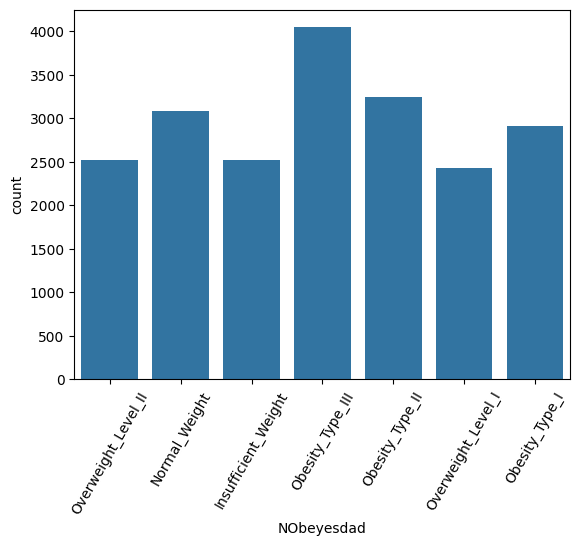

In [10]:
sns.countplot(data=data, x="NObeyesdad")
plt.xticks(rotation=60)
plt.show()

- The Dataset seems to be fairly balanced however, we will check the accuracy of the model with the current state of the dataset and with rebalancing it

In [11]:
# First will visualize all the numerical columns
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20758 entries, 0 to 20757
Data columns (total 17 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   Gender                          20758 non-null  object 
 1   Age                             20758 non-null  float64
 2   Height                          20758 non-null  float64
 3   Weight                          20758 non-null  float64
 4   family_history_with_overweight  20758 non-null  object 
 5   FAVC                            20758 non-null  object 
 6   FCVC                            20758 non-null  float64
 7   NCP                             20758 non-null  float64
 8   CAEC                            20758 non-null  object 
 9   SMOKE                           20758 non-null  object 
 10  CH2O                            20758 non-null  float64
 11  SCC                             20758 non-null  object 
 12  FAF                             

In [12]:
# First will visualize all the numerical columns
numeric = [x for x in data.columns if data[x].dtype in [int, float]]
numeric

['Age', 'Height', 'Weight', 'FCVC', 'NCP', 'CH2O', 'FAF', 'TUE']

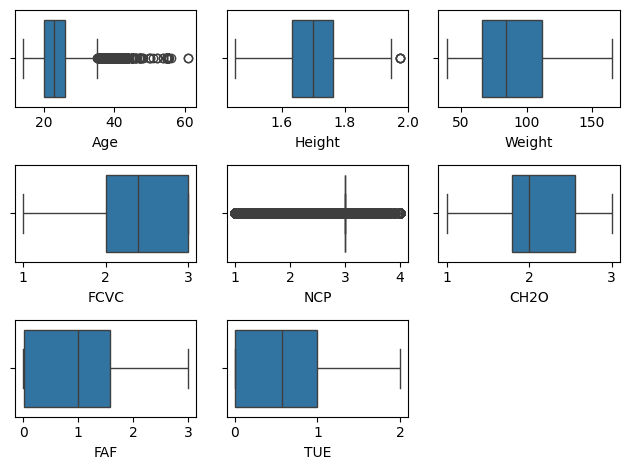

In [13]:

for index, column in enumerate(numeric):
  plt.subplot(3,3,index+1)
  sns.boxplot(data=data, x=column)
  plt.tight_layout()


- Everything seems to be alright except for NCP and AGE where outlier can be noticed
- Judging from the boxplots, majority of the poplulation seems to be under 40

In [14]:
# Let's define a fucntion to plot a count plot
def count_plot(x:str, hue=None, df=data, rotation=45, fontsize=14):
  sns.set_theme()
  sns.countplot(data=df, x=x, hue=hue)
  plt.title(f"Countplot for {x} with HUE as {hue}")
  plt.xticks(rotation=rotation, fontsize=fontsize)
  plt.yticks(fontsize=fontsize)

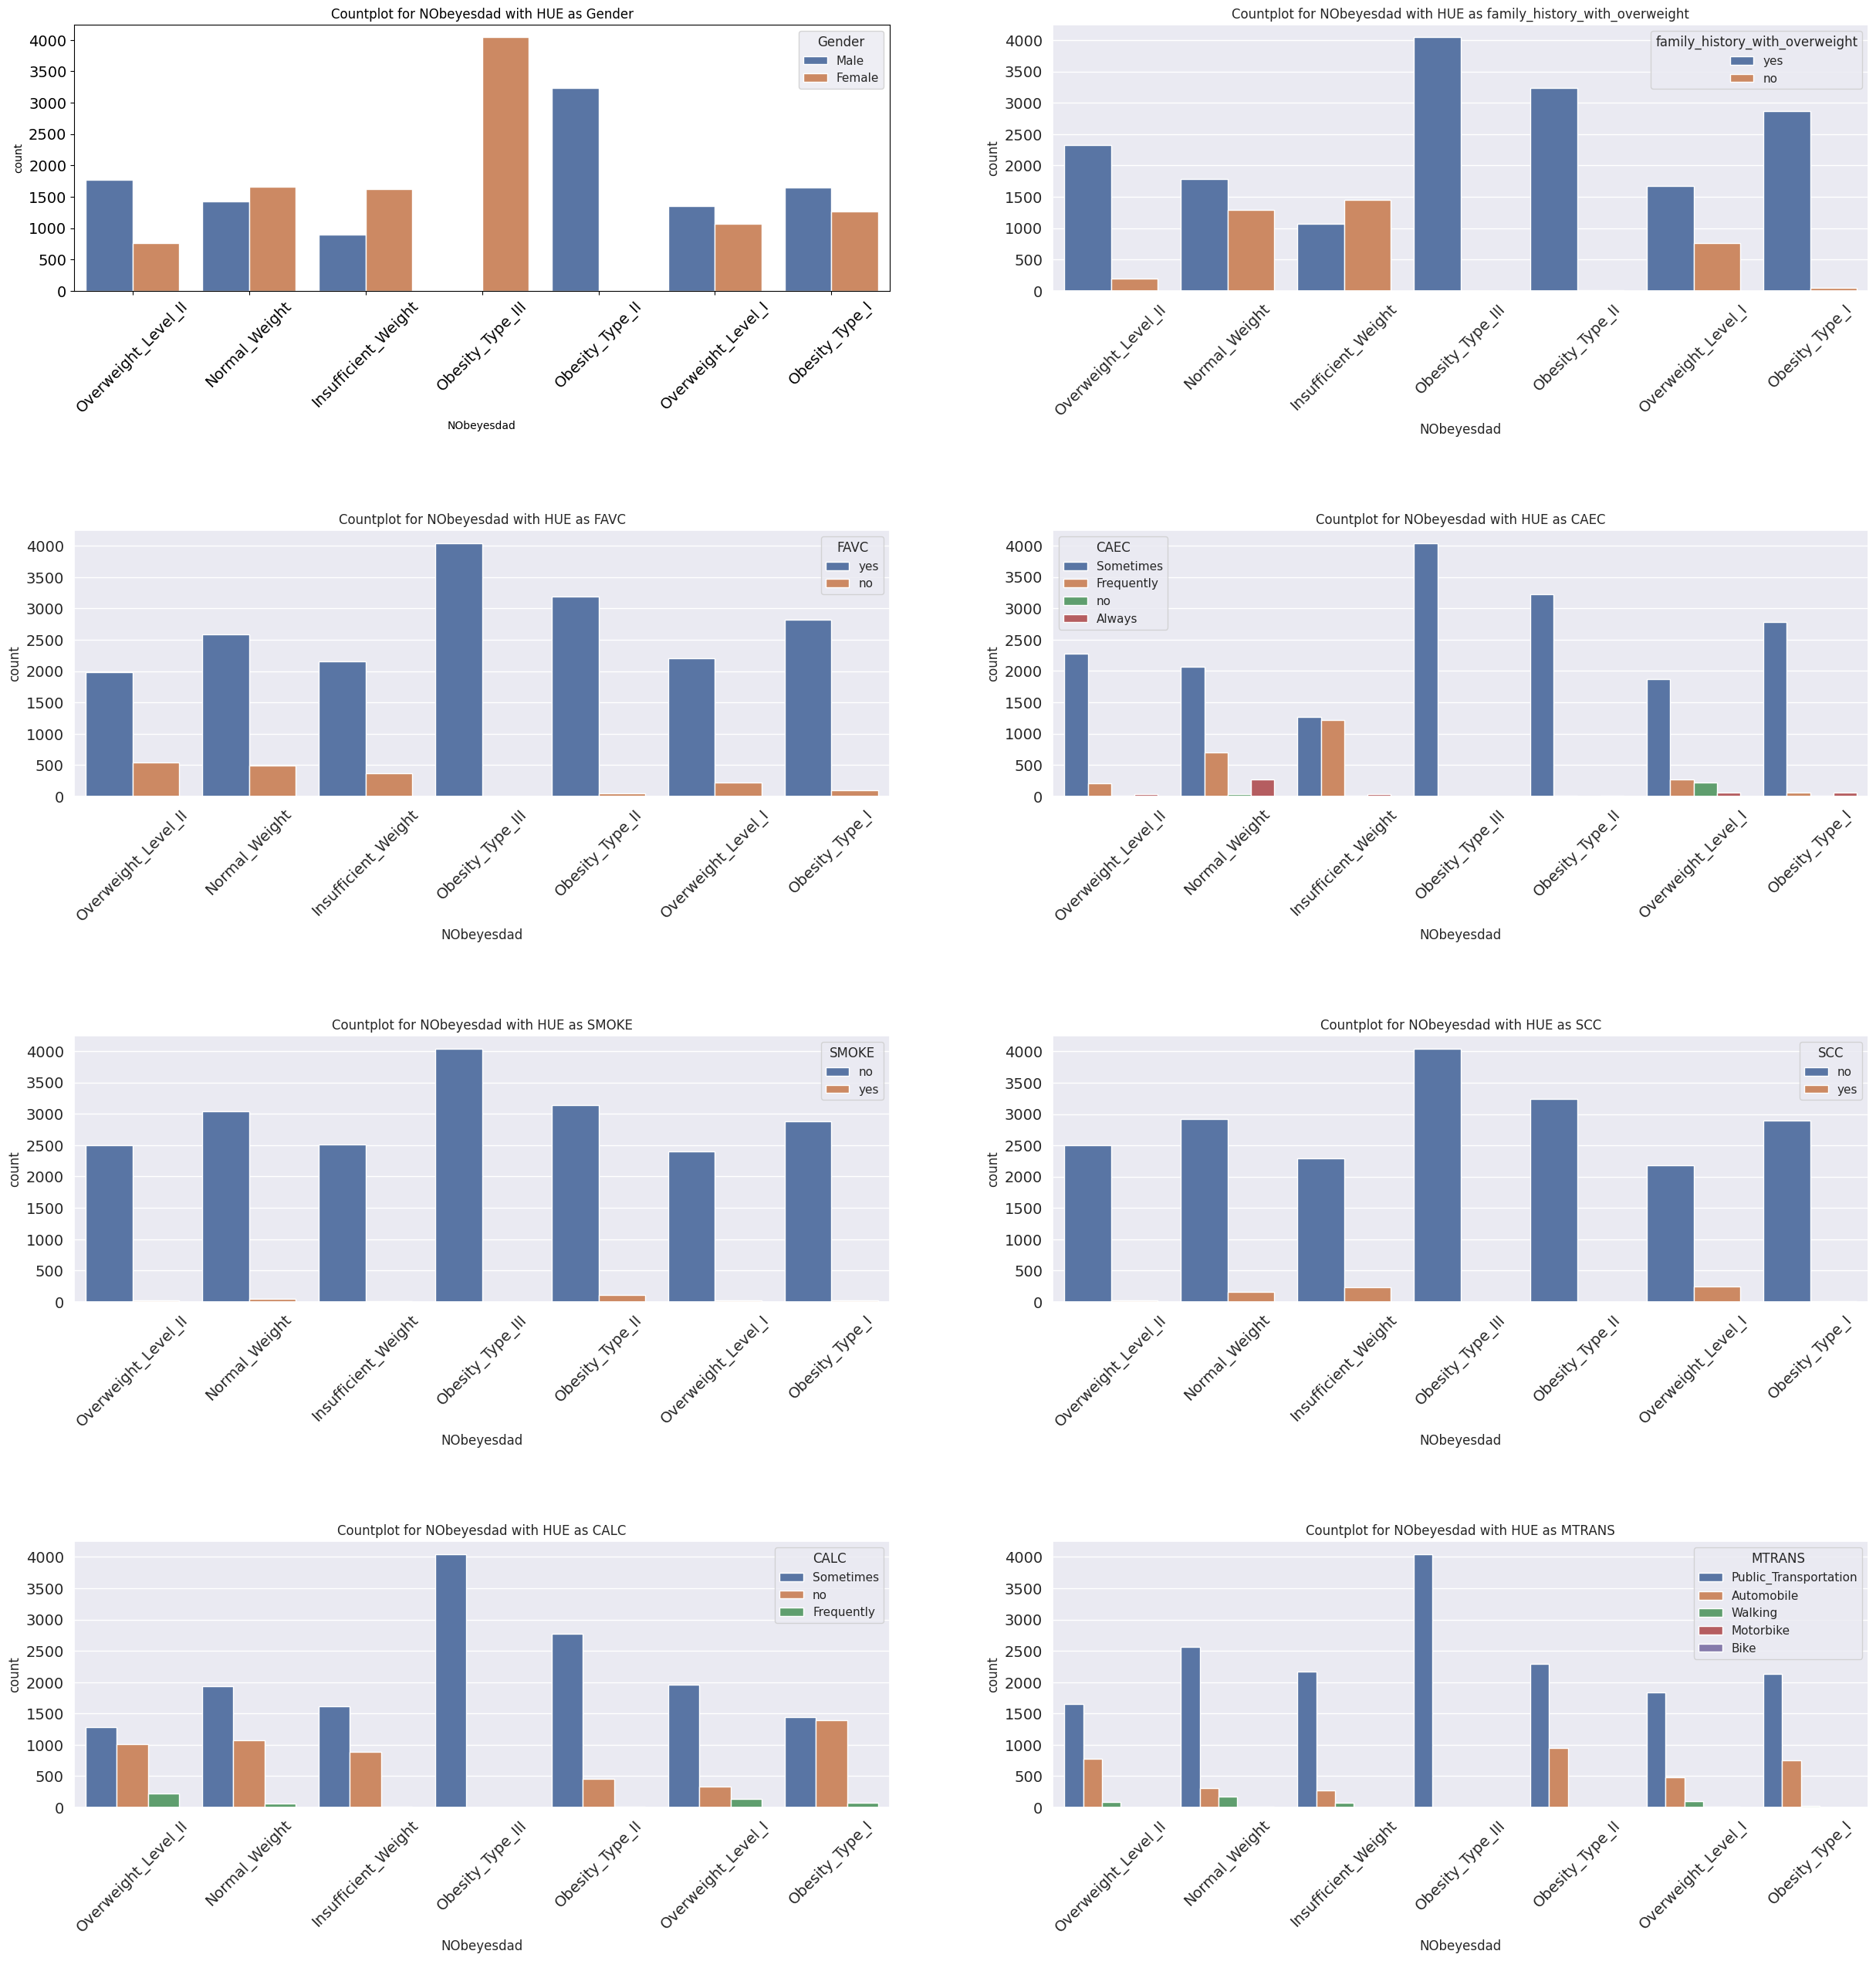

In [15]:
x = "NObeyesdad"
hue = [x for x in data.columns if data[x].dtype in [object]]
hue.remove("NObeyesdad")

for index, column in enumerate(hue):
  plt.subplot(4,2,index+1)
  count_plot(x=x, hue=column)
  plt.gcf().set_size_inches((30, 30))
  plt.subplots_adjust(hspace=0.9)

### Onservations:
- Nothing extra ordinary can be deduced except for some class imbalance in certrain features
- Let's address this in the following

In [16]:
def get_percent_cat(df:pd.DataFrame):

  for i in df.select_dtypes(include=[object]).columns:
    print(f"For {i}")
    print(df[i].value_counts()/df.shape[0] * 100,"\n")
get_percent_cat(data)

For Gender
Female    50.207149
Male      49.792851
Name: Gender, dtype: float64 

For family_history_with_overweight
yes    81.96358
no     18.03642
Name: family_history_with_overweight, dtype: float64 

For FAVC
yes    91.444262
no      8.555738
Name: FAVC, dtype: float64 

For CAEC
Sometimes     84.444551
Frequently    11.908662
Always         2.302727
no             1.344060
Name: CAEC, dtype: float64 

For SMOKE
no     98.819732
yes     1.180268
Name: SMOKE, dtype: float64 

For SCC
no     96.690433
yes     3.309567
Name: SCC, dtype: float64 

For CALC
Sometimes     72.579247
no            24.872338
Frequently     2.548415
Name: CALC, dtype: float64 

For MTRANS
Public_Transportation    80.388284
Automobile               17.024762
Walking                   2.249735
Motorbike                 0.183062
Bike                      0.154157
Name: MTRANS, dtype: float64 

For NObeyesdad
Obesity_Type_III       19.491280
Obesity_Type_II        15.646979
Normal_Weight          14.847288
Obesi

Most of the classes seems to be unbalanced in our predicter variables, either we drop them or bin them

In [17]:
data.select_dtypes(include=[int, float]).columns

Index(['Age', 'Height', 'Weight', 'FCVC', 'NCP', 'CH2O', 'FAF', 'TUE'], dtype='object')

In [18]:
data.select_dtypes(include=[object]).columns

Index(['Gender', 'family_history_with_overweight', 'FAVC', 'CAEC', 'SMOKE',
       'SCC', 'CALC', 'MTRANS', 'NObeyesdad'],
      dtype='object')

In [19]:

# Now we will bin the categorical variables or drop them based on some pre notion i.e highly skewed variables would be discarded
# We will set the cutoff percentage to be 80%

for index in data.select_dtypes(include=[object]).columns:
  if max((data[index].value_counts()/data.shape[0] * 100).values) > 81:
    print(index)

family_history_with_overweight
FAVC
CAEC
SMOKE
SCC


In [20]:
# We will drop SMOKE, SCC and FAVC since they are extremely skewed
data.drop(["SMOKE", "SCC", "FAVC"], axis=1, inplace=True)

In [21]:
get_percent_cat(data)




For Gender
Female    50.207149
Male      49.792851
Name: Gender, dtype: float64 

For family_history_with_overweight
yes    81.96358
no     18.03642
Name: family_history_with_overweight, dtype: float64 

For CAEC
Sometimes     84.444551
Frequently    11.908662
Always         2.302727
no             1.344060
Name: CAEC, dtype: float64 

For CALC
Sometimes     72.579247
no            24.872338
Frequently     2.548415
Name: CALC, dtype: float64 

For MTRANS
Public_Transportation    80.388284
Automobile               17.024762
Walking                   2.249735
Motorbike                 0.183062
Bike                      0.154157
Name: MTRANS, dtype: float64 

For NObeyesdad
Obesity_Type_III       19.491280
Obesity_Type_II        15.646979
Normal_Weight          14.847288
Obesity_Type_I         14.018692
Insufficient_Weight    12.154350
Overweight_Level_II    12.149533
Overweight_Level_I     11.691878
Name: NObeyesdad, dtype: float64 



In [22]:
data = data[~data["CAEC"].isin(["Always", "no"])]

In [23]:
get_percent_cat(data)

For Gender
Female    50.462477
Male      49.537523
Name: Gender, dtype: float64 

For family_history_with_overweight
yes    82.840858
no     17.159142
Name: family_history_with_overweight, dtype: float64 

For CAEC
Sometimes     87.640618
Frequently    12.359382
Name: CAEC, dtype: float64 

For CALC
Sometimes     72.851357
no            24.658767
Frequently     2.489876
Name: CALC, dtype: float64 

For MTRANS
Public_Transportation    80.370981
Automobile               17.204140
Walking                   2.129894
Motorbike                 0.164992
Bike                      0.129994
Name: MTRANS, dtype: float64 

For NObeyesdad
Obesity_Type_III       20.223989
Obesity_Type_II        16.179191
Obesity_Type_I         14.189291
Normal_Weight          13.854307
Overweight_Level_II    12.414379
Insufficient_Weight    12.399380
Overweight_Level_I     10.739463
Name: NObeyesdad, dtype: float64 



In [24]:
# We will bin the under represented categories into "others"

data["MTRANS"] = data["MTRANS"].replace(["Walking", "Motorbike", "Bike"], "walk_two_wheelers")

<ipython-input-24-c719cb4c8122>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data["MTRANS"] = data["MTRANS"].replace(["Walking", "Motorbike", "Bike"], "walk_two_wheelers")


In [25]:
cat_col = list(data.select_dtypes(include=[object]).columns)
numeric_col = list(data.select_dtypes(include=[float, int]).columns)
cat_col, numeric_col

(['Gender',
  'family_history_with_overweight',
  'CAEC',
  'CALC',
  'MTRANS',
  'NObeyesdad'],
 ['Age', 'Height', 'Weight', 'FCVC', 'NCP', 'CH2O', 'FAF', 'TUE'])

### Bivariate Analysis

In [26]:
def plot_bivariate(x:str, y:str, boxplot=False, barplot=False, stripplot=False,df=data, rotation=45, fontsize=14, hue=None, estimator="mean"):

  if barplot:
    sns.color_palette("rocket")
    sns.barplot(data=df, x=x, y=y, estimator=estimator, hue=hue)
    plt.title(f"Barplot for {x} vs {y}")
    plt.xticks(rotation=rotation, fontsize=fontsize)
    plt.yticks(fontsize=fontsize)

  elif stripplot:
    sns.stripplot(data=df, x=x, y=y, hue=hue)
    plt.title(f"Barplot for {x} vs {y}")
    plt.xticks(rotation=rotation, fontsize=fontsize)
    plt.yticks(fontsize=fontsize)

  elif boxplot:
    sns.color_palette("rocket")
    sns.boxplot(data=df, x=x, y=y, hue=hue)
    plt.title(f"Barplot for {x} vs {y}")
    plt.xticks(rotation=rotation, fontsize=fontsize)
    plt.yticks(fontsize=fontsize)

  else:
    print("Set the boolean for boxplot, stripplot or barplot to True")




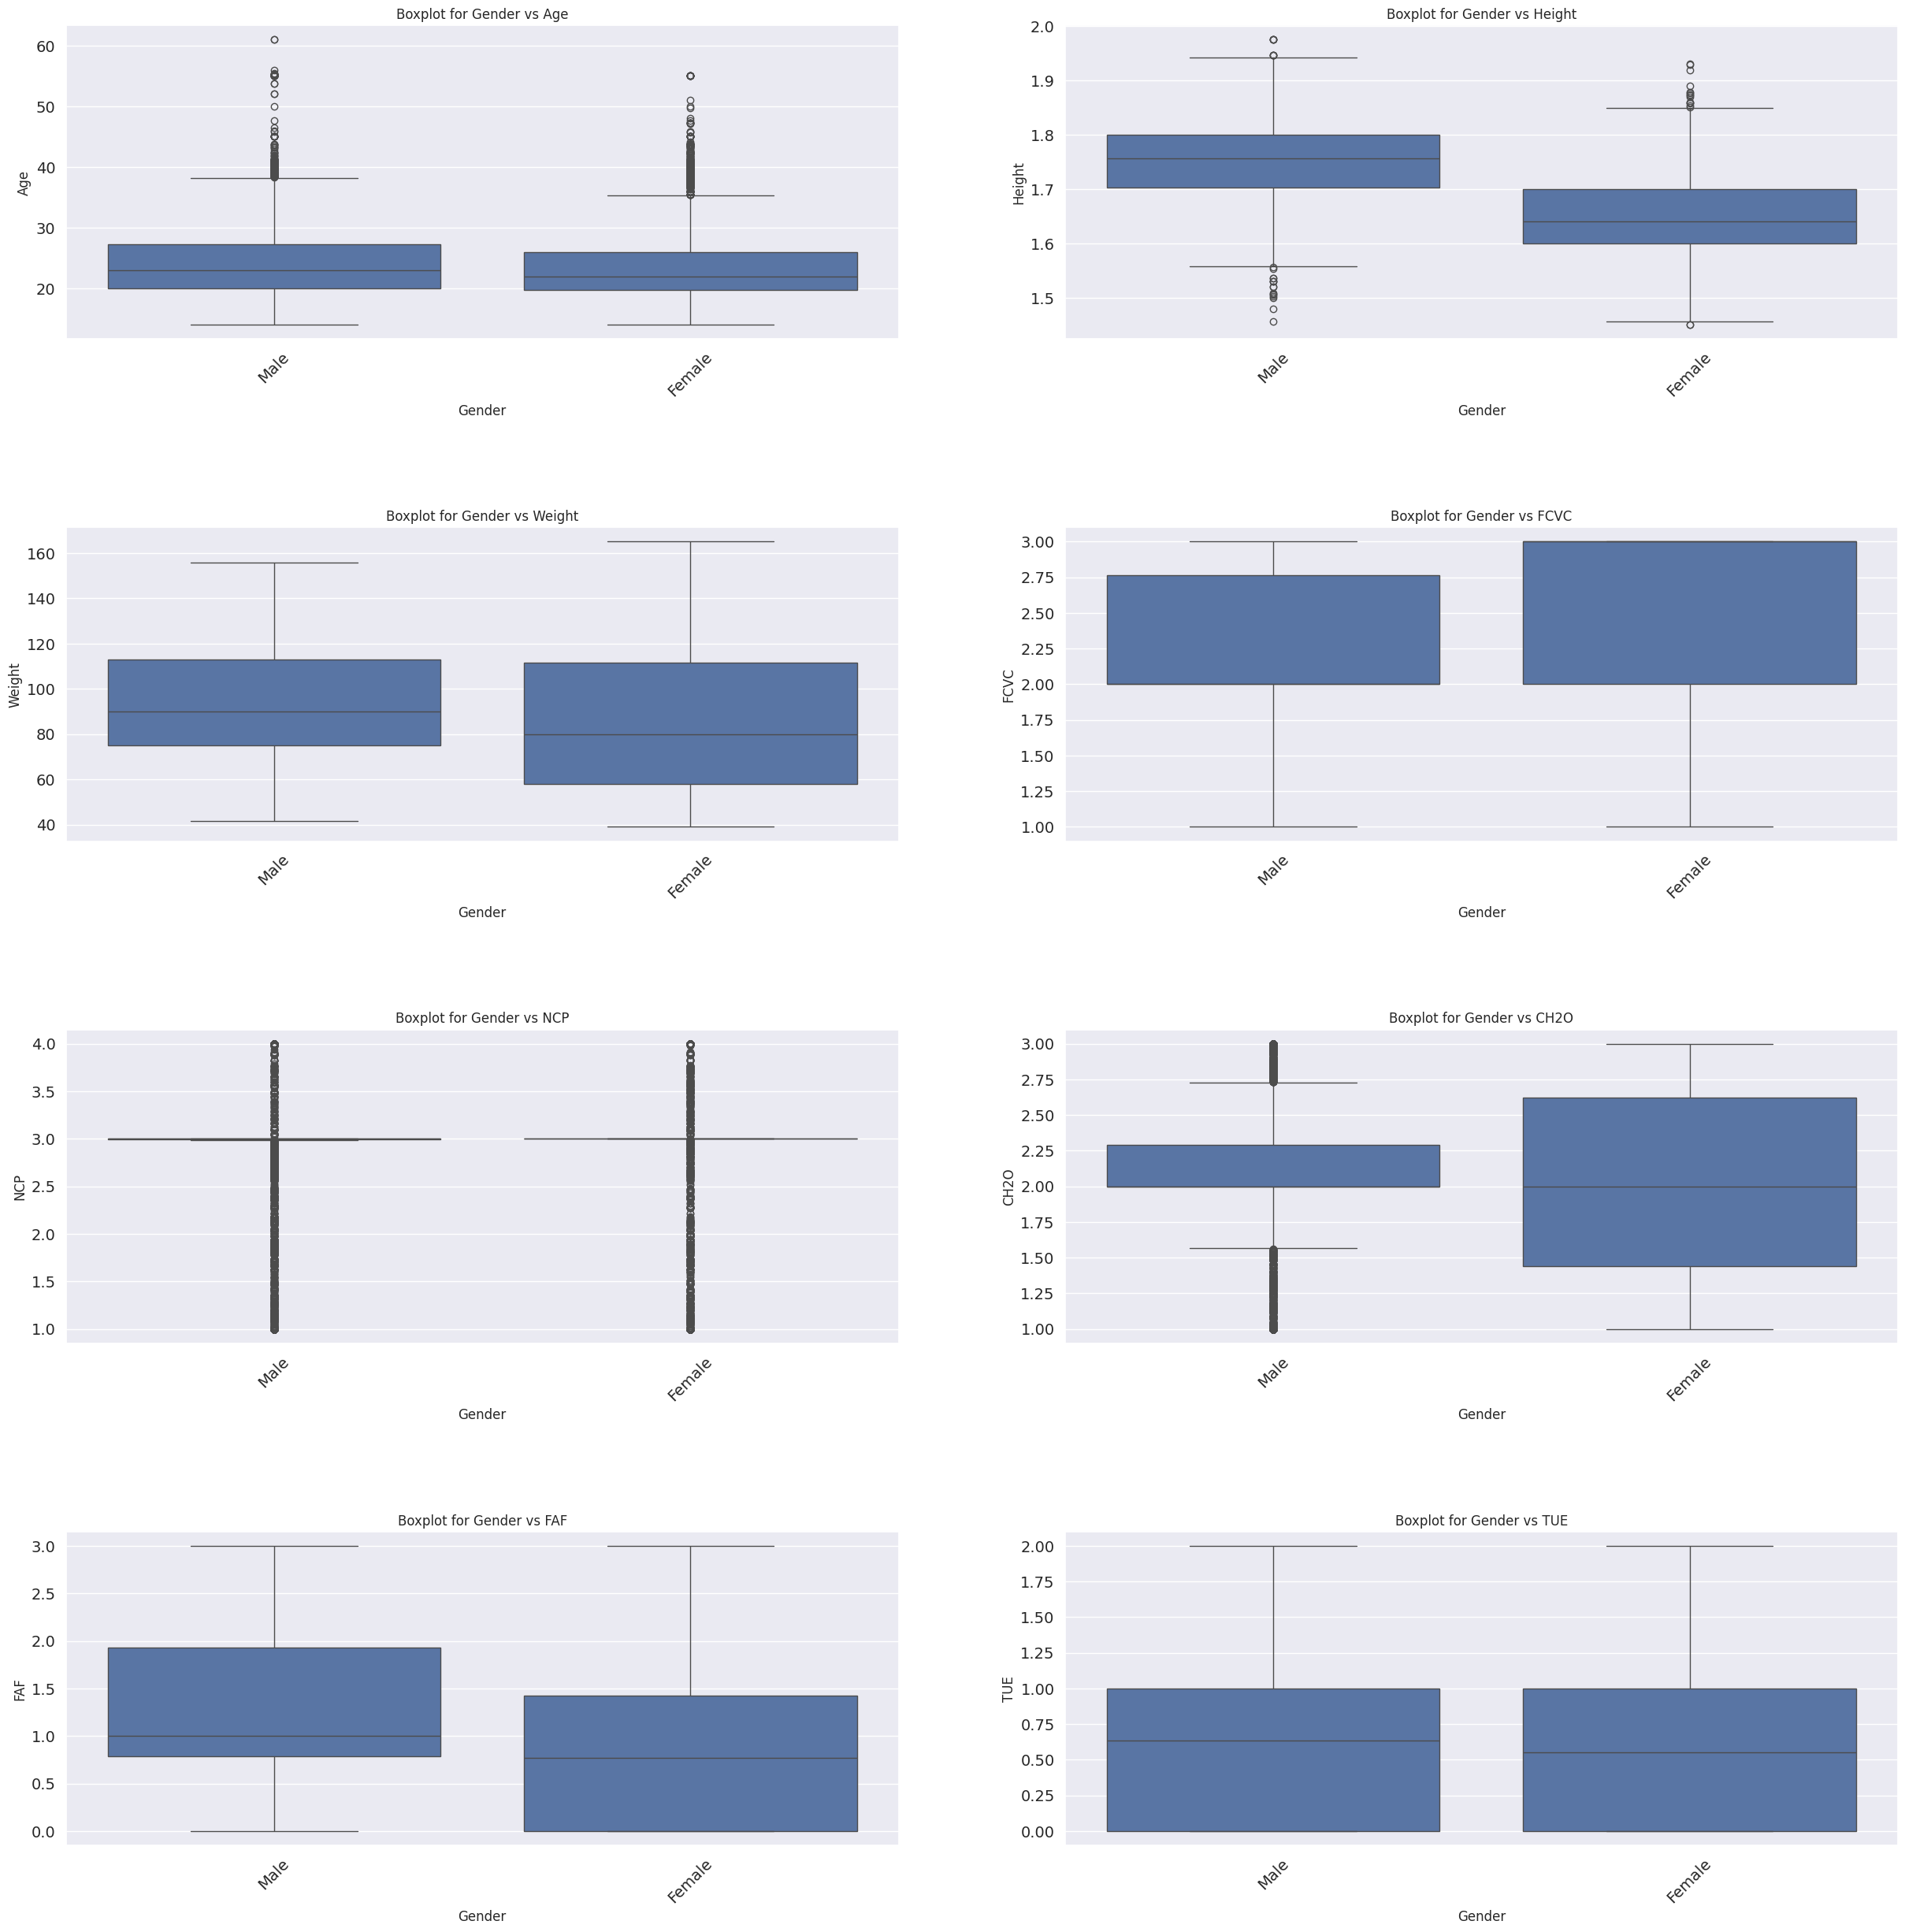

In [27]:
x = cat_col[0]
sns.color_palette("rocket")
for index, column in enumerate(numeric_col):

  plt.subplot(4,2,index+1)
  plot_bivariate(x=x, y=column, boxplot=True)
  plt.gcf().set_size_inches((30, 30))
  plt.title(f"Boxplot for {x} vs {column}")
  plt.subplots_adjust(hspace=0.6)

 - Age wise we can see that most of them lie below 40, although there are some outliers
 - Height wise it seems that the MALEs have more height as comapred to their female counterparts
 - Weight wise it seems that the males weight slightly lower than females, this could mean that there exists correlation between height and weight columns
 - Not much has been revealed to us in the context of what those values mean but from what is provided to us we can say that the consumption of vegetables are higher for the females
 - Consumption of water is more evenly spread out for females indicating that the diversity for females is maintained but for the males it from the plot it seems that they consume less water
 - Physical acitivity seems to be high for the males

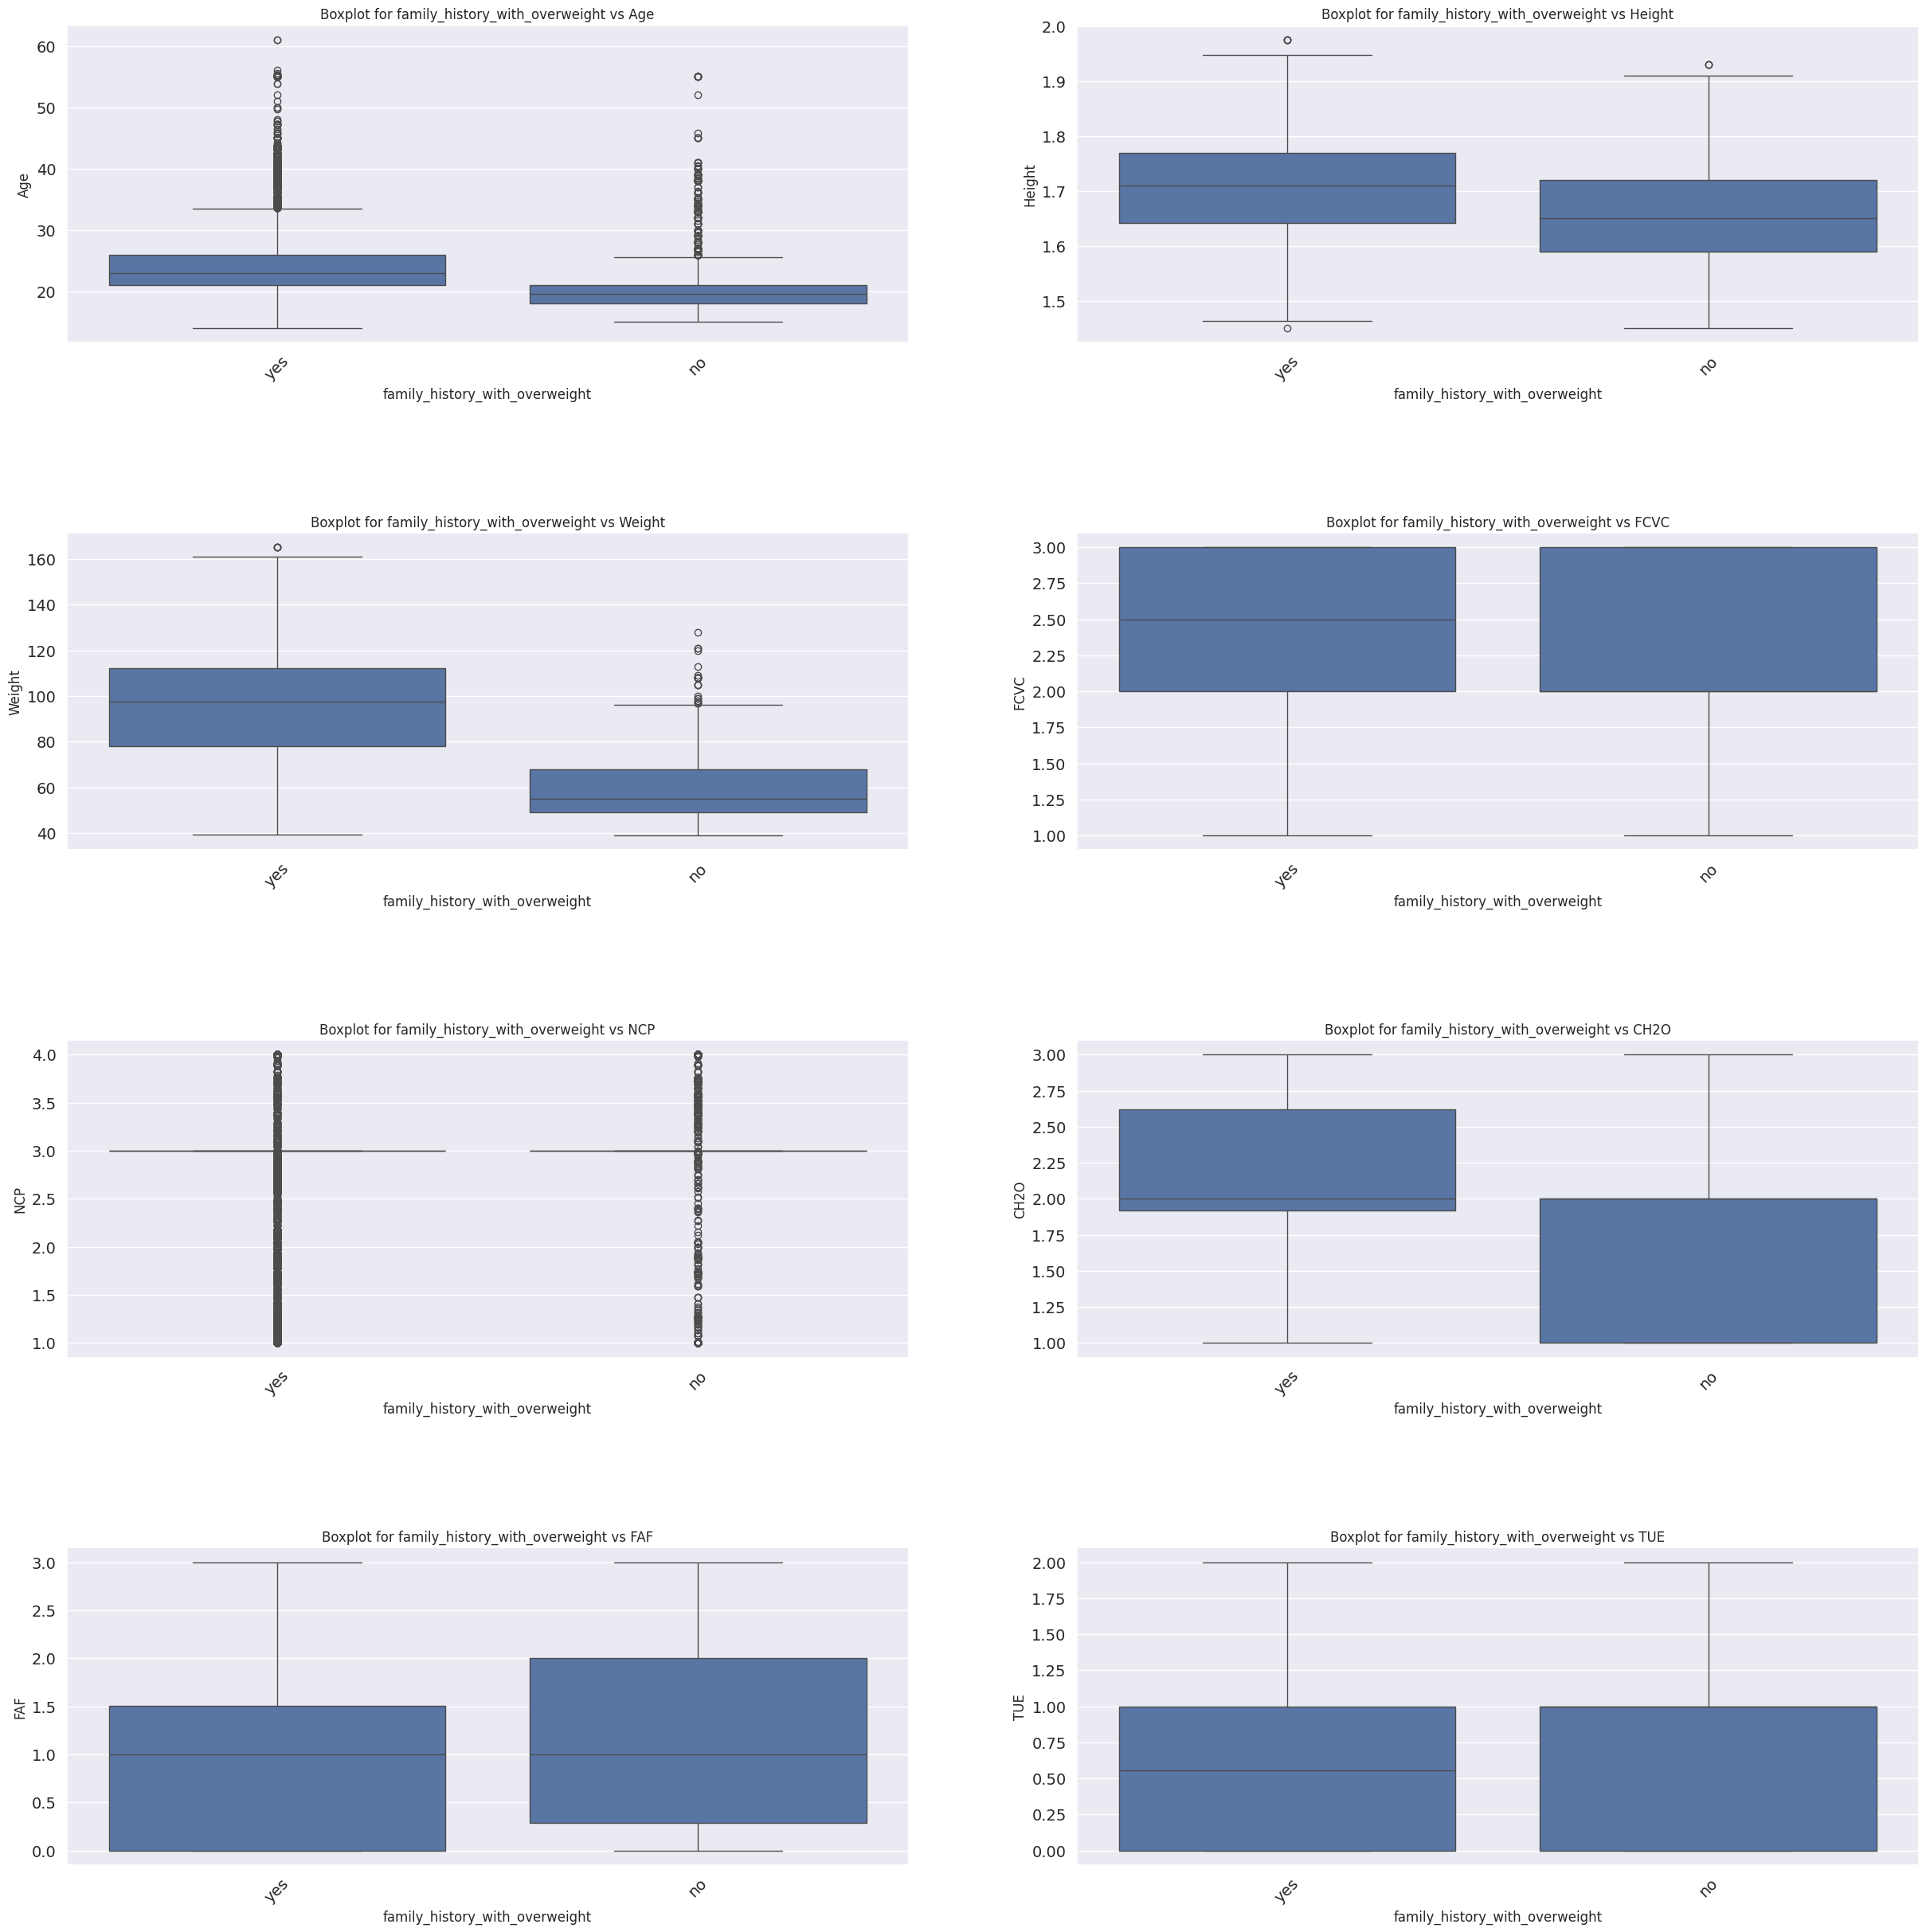

In [28]:
x = cat_col[1]

for index, column in enumerate(numeric_col):
  plt.subplot(4,2,index+1)
  plot_bivariate(x=x, y=column, boxplot=True, estimator="median")
  plt.gcf().set_size_inches((30, 30))
  plt.title(f"Boxplot for {x} vs {column}")
  plt.subplots_adjust(hspace=0.6)

- Weight wise it is clear that there seems to be a trend with the ones who dont have a history of obesity seems to be on the lower end
- The same is noticed w.r.t the consumption of water and  with the frequency of physical activity

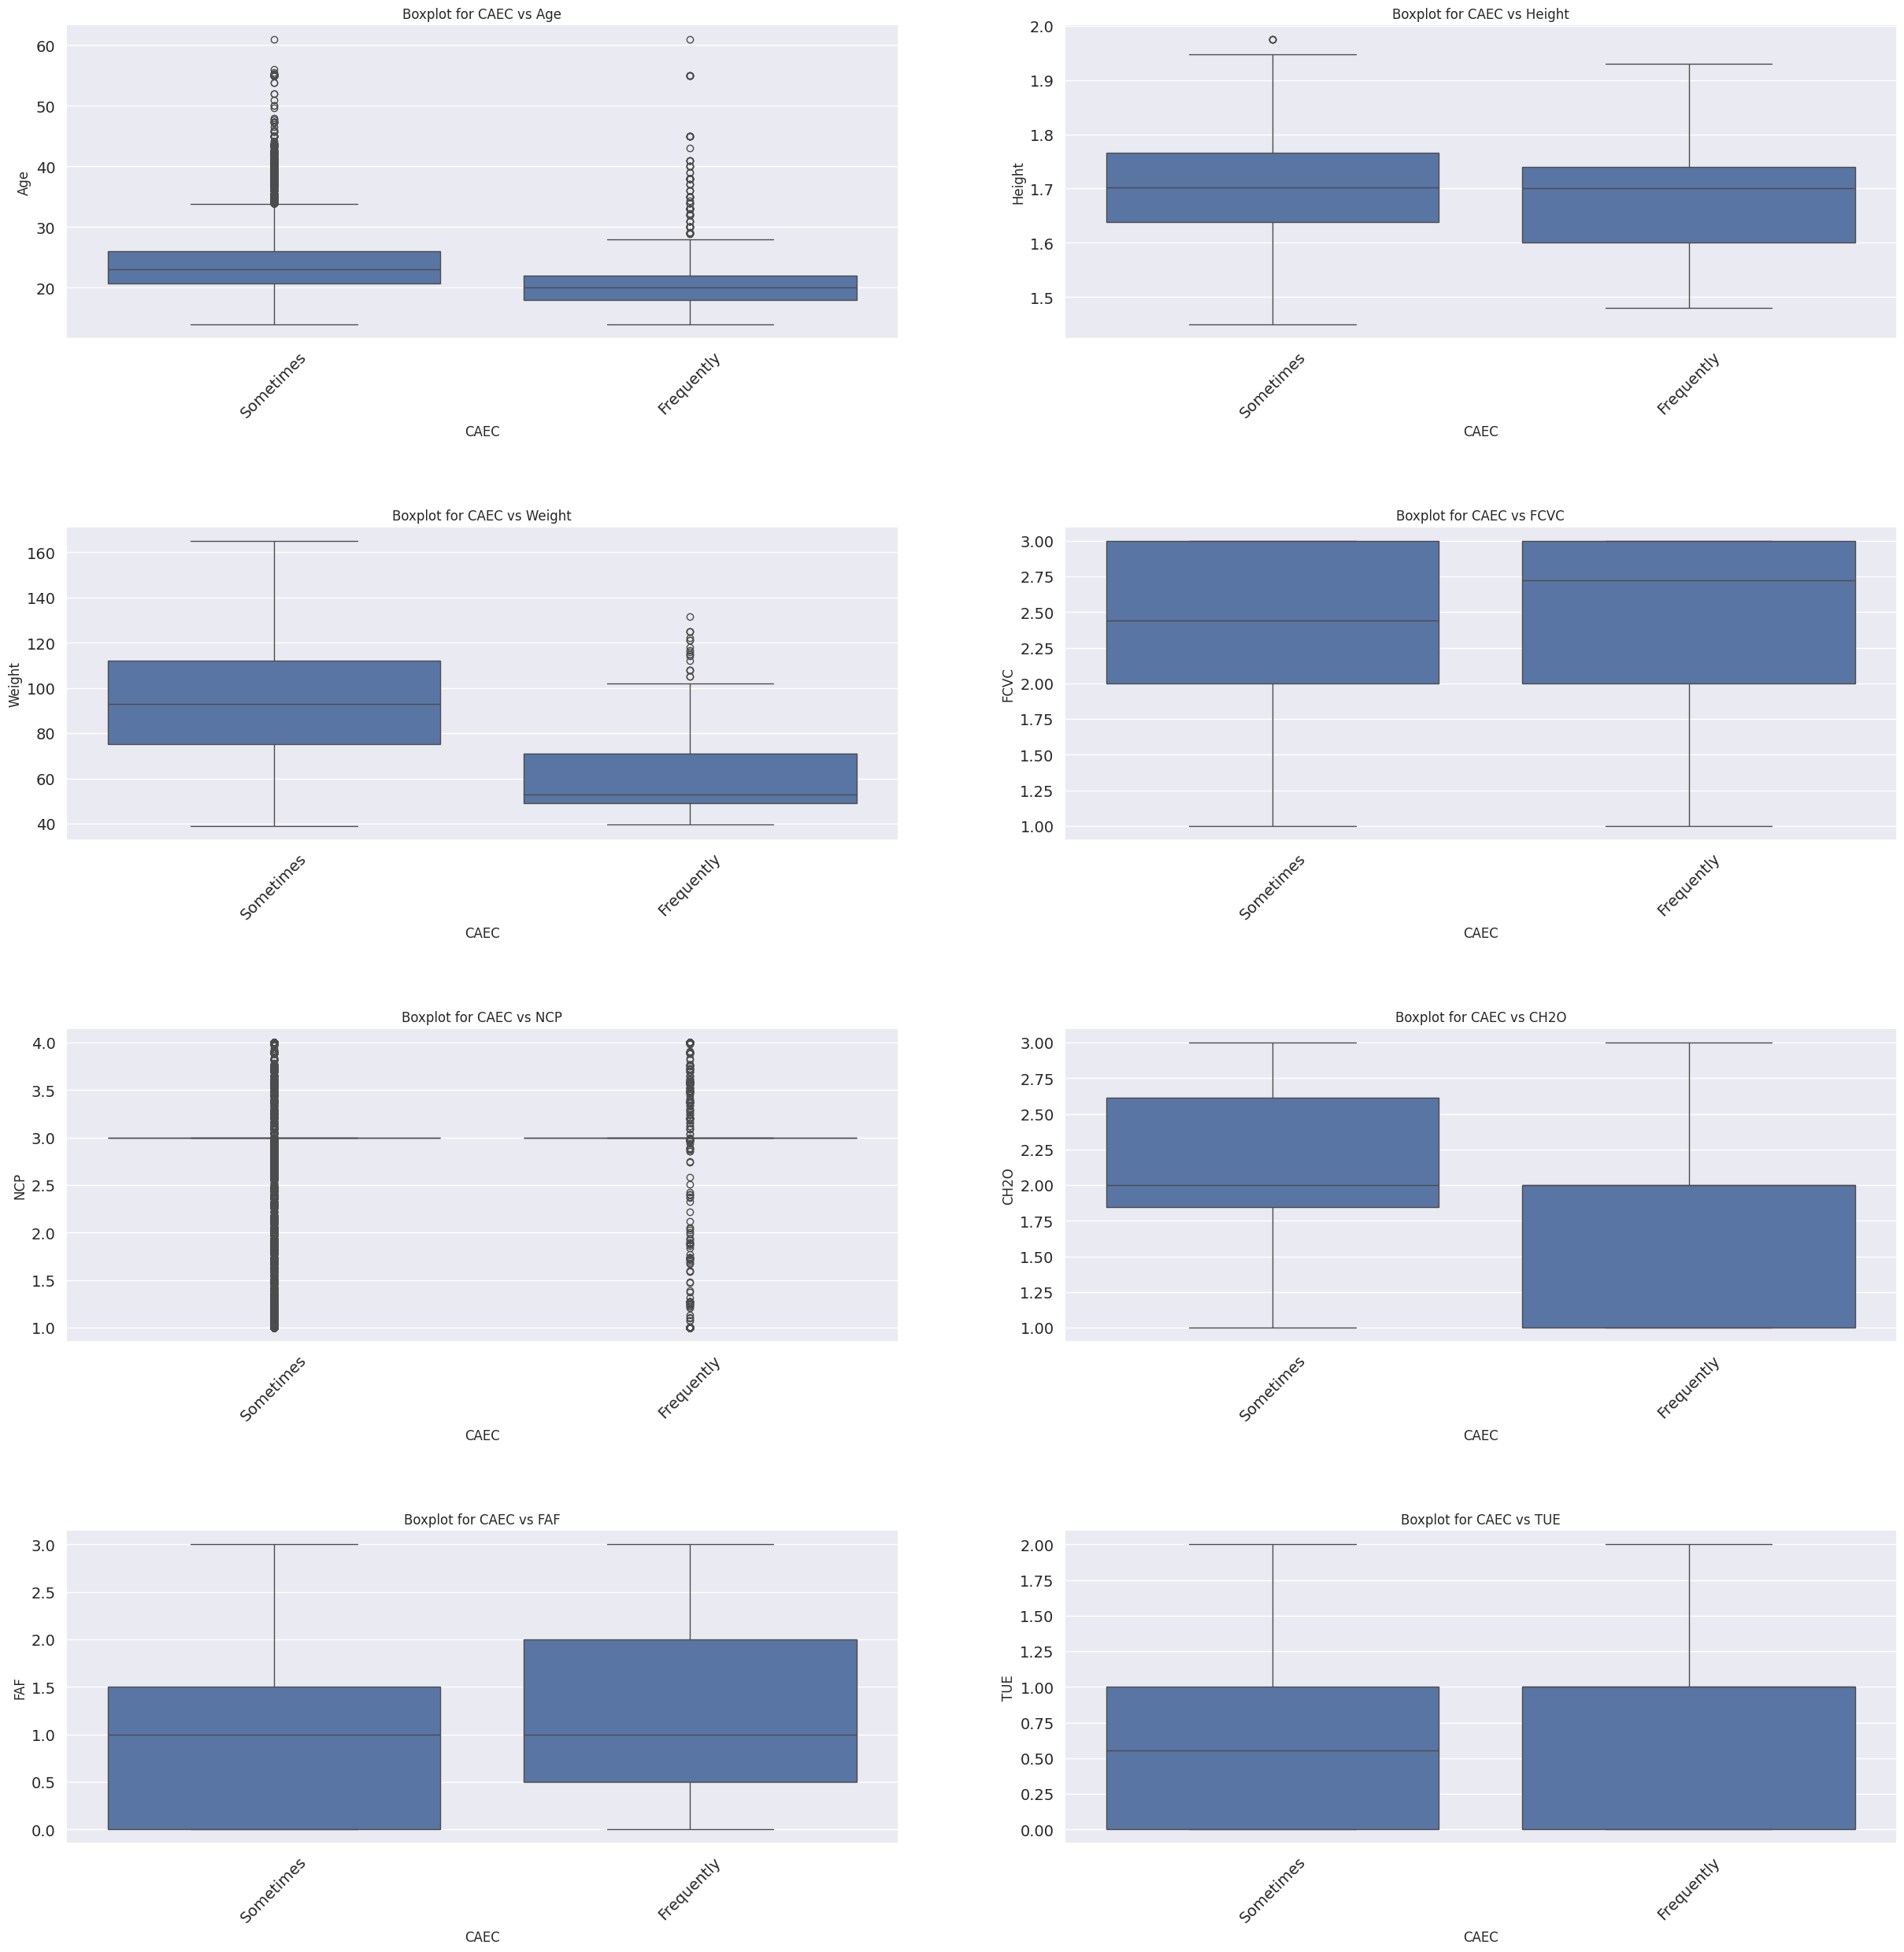

In [29]:
x = cat_col[2]

for index, column in enumerate(numeric_col):
  plt.subplot(4,2,index+1)
  plot_bivariate(x=x, y=column, boxplot=True)
  plt.gcf().set_size_inches((30, 30))
  plt.title(f"Boxplot for {x} vs {column}")
  plt.subplots_adjust(hspace=0.6)

- Data imbalance can be seen in most of the plots
- The observations from the above arent reliable enough to draw conclusions

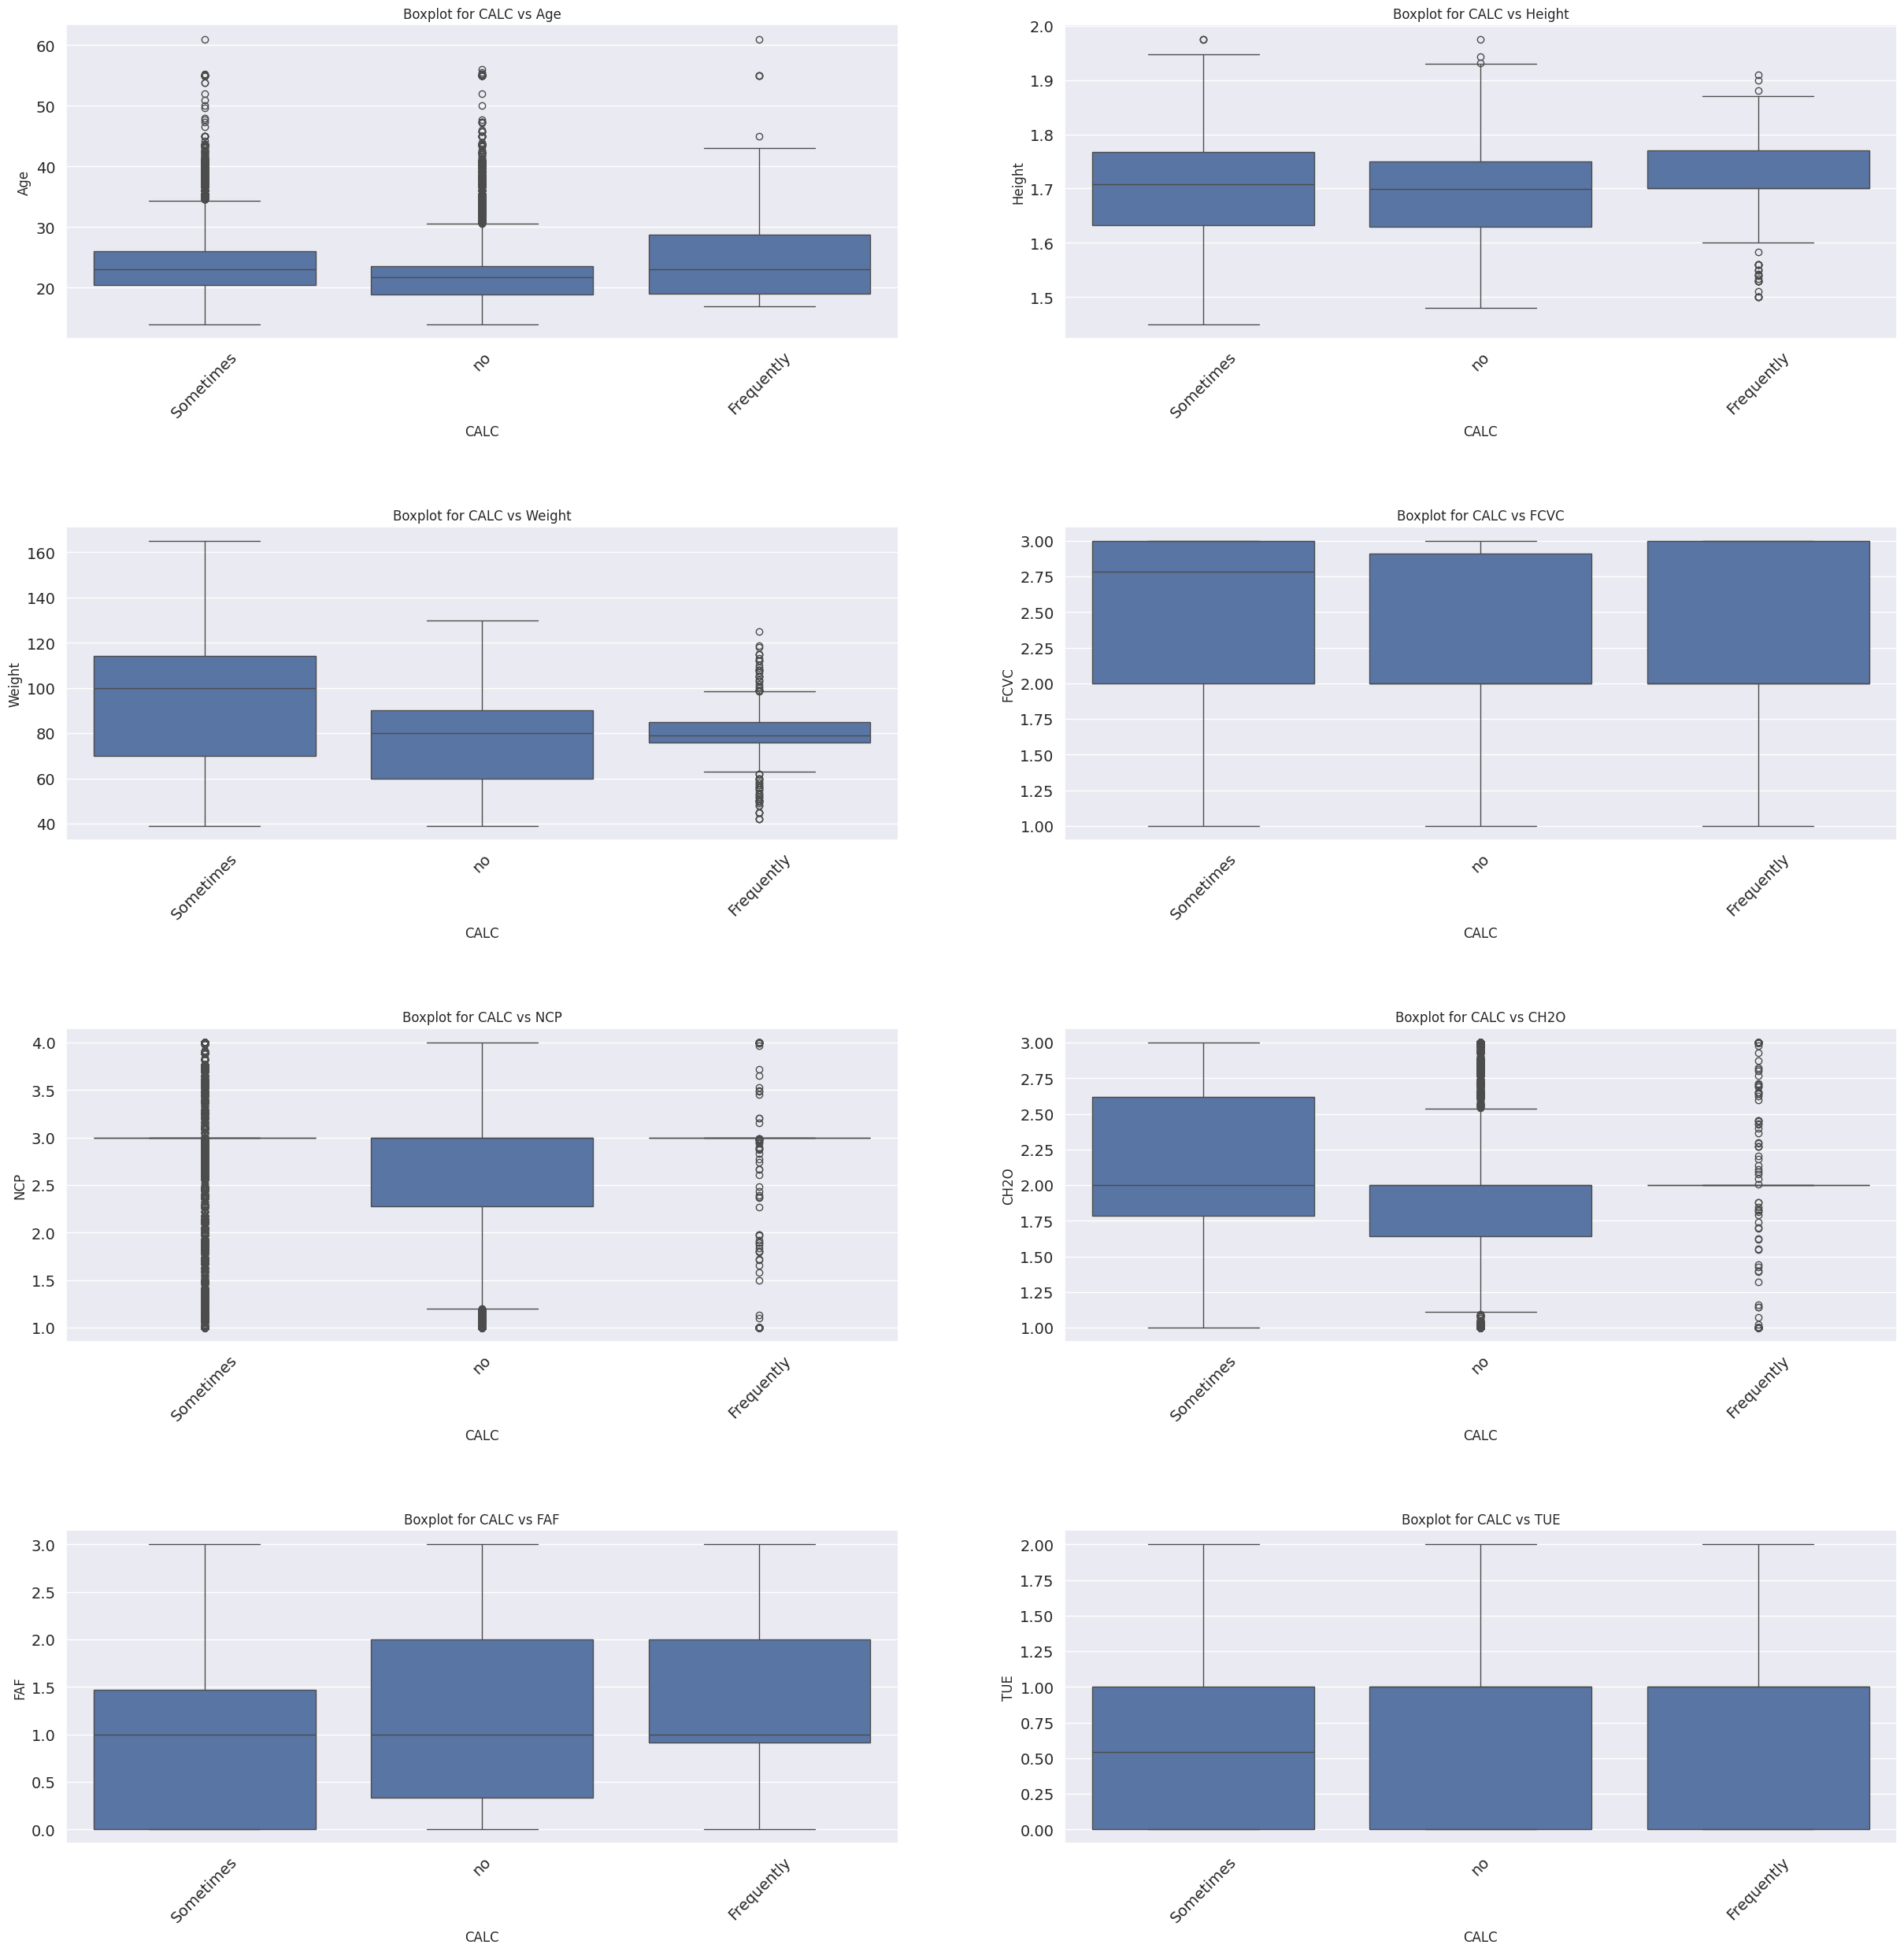

In [30]:


x = cat_col[3]

for index, column in enumerate(numeric_col):
  sns.cubehelix_palette(start=2, rot=0, dark=0, light=.95, reverse=True, as_cmap=True)
  plt.subplot(4,2,index+1)
  plot_bivariate(x=x, y=column, boxplot=True)
  plt.gcf().set_size_inches((30, 30))
  plt.title(f"Boxplot for {x} vs {column}")
  plt.subplots_adjust(hspace=0.6)

- The data seems to be biased around the category "Sometimes", no conclusive pattern can be opbserved

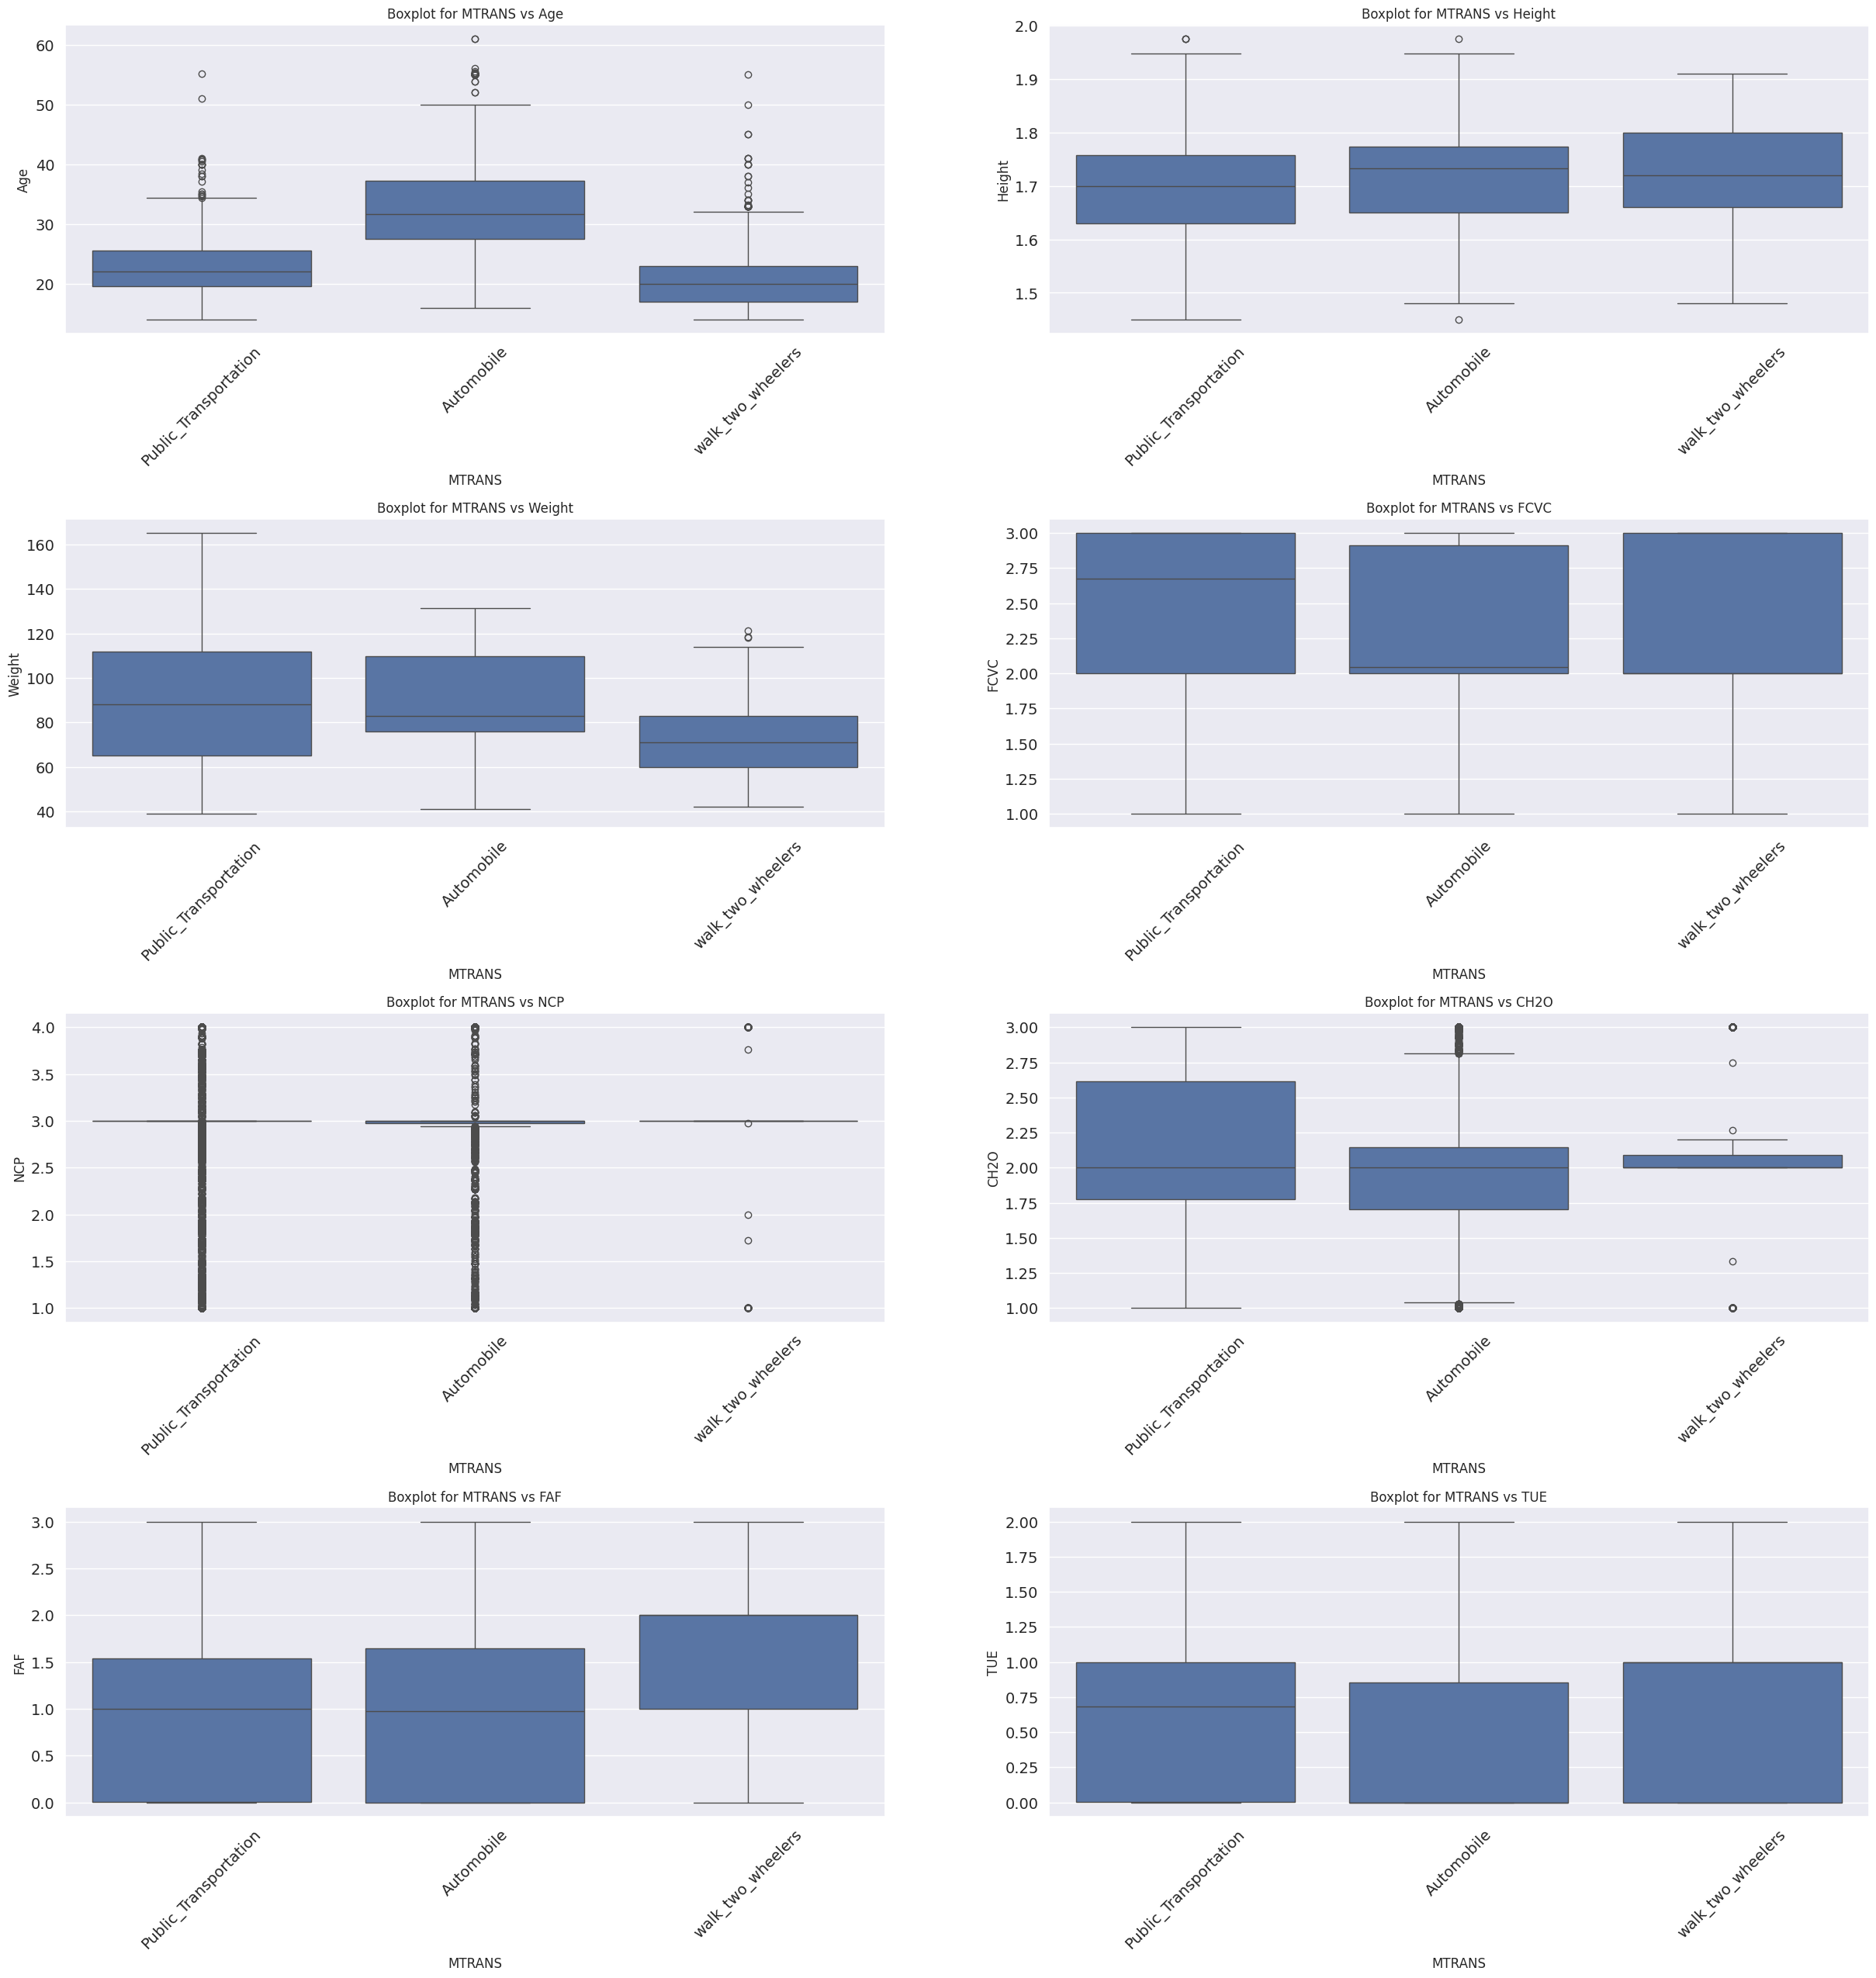

In [31]:
x = cat_col[4]

for index, column in enumerate(numeric_col):
  plt.subplot(4,2,index+1)
  plot_bivariate(x=x, y=column, boxplot=True)
  plt.gcf().set_size_inches((30, 30))
  plt.title(f"Boxplot for {x} vs {column}")
  plt.subplots_adjust(hspace=0.6)

- People of higher weight usually tend to take public transportation as opposed to a car or a bike or a cycle
- Also people with higer frequency of physical activity are more likely to opt for cycling and motor biking

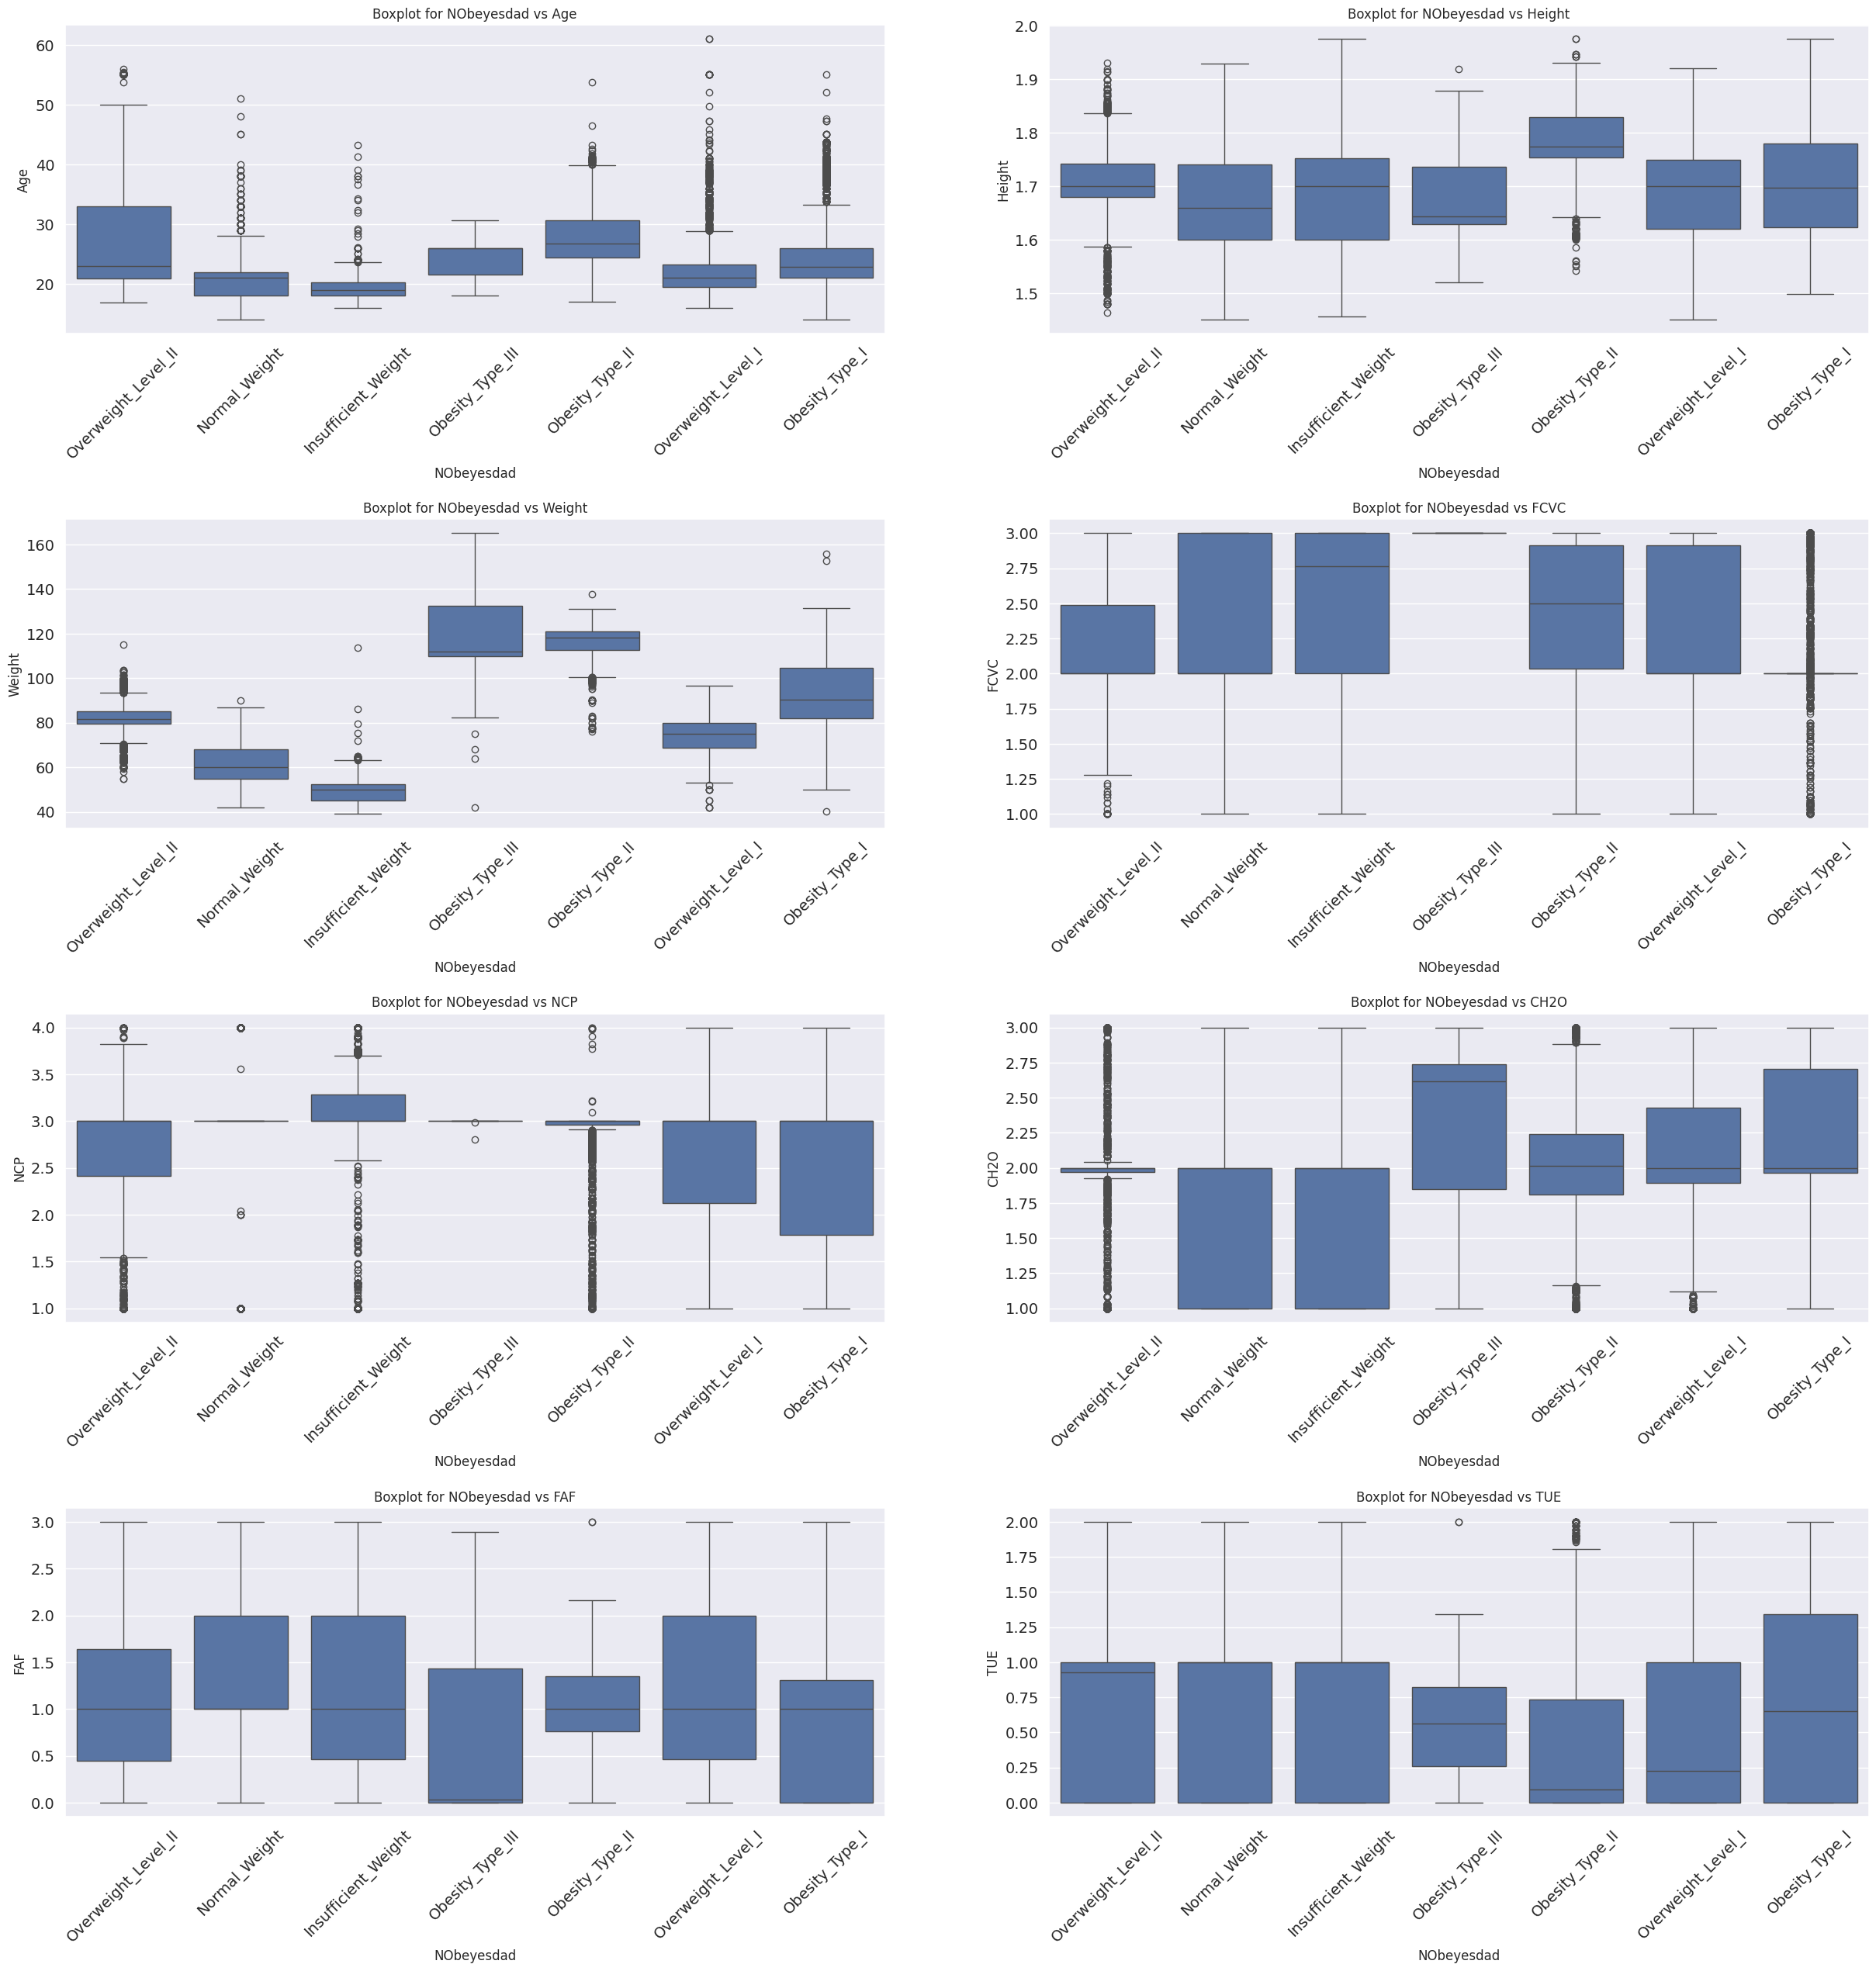

In [32]:
x = cat_col[5]

for index, column in enumerate(numeric_col):
  plt.subplot(4,2,index+1)
  plot_bivariate(x=x, y=column, boxplot=True)
  plt.gcf().set_size_inches((30, 30))
  plt.title(f"Boxplot for {x} vs {column}")
  plt.subplots_adjust(hspace=0.6)

### Let's look at multivariate analysis

In [33]:
cat_col, numeric_col

(['Gender',
  'family_history_with_overweight',
  'CAEC',
  'CALC',
  'MTRANS',
  'NObeyesdad'],
 ['Age', 'Height', 'Weight', 'FCVC', 'NCP', 'CH2O', 'FAF', 'TUE'])

In [34]:
# ['NObeyesdad', 'weight', "CAEC"]
# ['NObeyesdad', 'weight', "FAF"]
# ['NObeyesdad', 'weight', "CH2O"]
# ['NObeyesdad', 'weight', "MTRANS"]
# ['NObeyesdad', 'weight', "MTRANS"]
# According to all the plots observed above are few of the graphs which may help derive addtional insights
# Let's ecnode these variables for better visualizations

get_percent_cat(df=data)

For Gender
Female    50.462477
Male      49.537523
Name: Gender, dtype: float64 

For family_history_with_overweight
yes    82.840858
no     17.159142
Name: family_history_with_overweight, dtype: float64 

For CAEC
Sometimes     87.640618
Frequently    12.359382
Name: CAEC, dtype: float64 

For CALC
Sometimes     72.851357
no            24.658767
Frequently     2.489876
Name: CALC, dtype: float64 

For MTRANS
Public_Transportation    80.370981
Automobile               17.204140
walk_two_wheelers         2.424879
Name: MTRANS, dtype: float64 

For NObeyesdad
Obesity_Type_III       20.223989
Obesity_Type_II        16.179191
Obesity_Type_I         14.189291
Normal_Weight          13.854307
Overweight_Level_II    12.414379
Insufficient_Weight    12.399380
Overweight_Level_I     10.739463
Name: NObeyesdad, dtype: float64 



In [35]:
def encoder(df, encoder)->Tuple[pd.DataFrame, pd.DataFrame]:
  encodings = pd.DataFrame()
  for i in df.select_dtypes(object).columns:
    temp_df = pd.DataFrame()
    df[i] = encoder.fit_transform(df[i])
    temp = df[i].copy()
    actuals = encoder.inverse_transform(temp)
    temp_df[f"enc_{i}"] = temp
    temp_df[f"act_{i}"] = actuals
    temp_df = temp_df.drop_duplicates()
    temp_df.reset_index(inplace=True)
    temp_df.drop("index", axis=1, inplace=True)
    encodings = pd.concat([encodings, temp_df], axis=1)
    # encodings.reset_index(drop=True, inplace=True)
  encodings.fillna("", inplace=True)
  return df, encodings



enc = LabelEncoder()
df1, encod = encoder(data, enc)








<ipython-input-35-38e5b6ad3f13>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[i] = encoder.fit_transform(df[i])
<ipython-input-35-38e5b6ad3f13>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[i] = encoder.fit_transform(df[i])
<ipython-input-35-38e5b6ad3f13>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guid

In [36]:
df1.head()

,Gender,Age,Height,Weight,family_history_with_overweight,FCVC,NCP,CAEC,CH2O,FAF,TUE,CALC,MTRANS,NObeyesdad
0,1,24.443011,1.699998,81.669950,1,2.000000,2.983297,1,2.763573,0.000000,0.976473,1,1,6
1,0,18.000000,1.560000,57.000000,1,2.000000,3.000000,0,2.000000,1.000000,1.000000,2,0,1
2,0,18.000000,1.711460,50.165754,1,1.880534,1.411685,1,1.910378,0.866045,1.673584,2,1,0
3,0,20.952737,1.710730,131.274851,1,3.000000,3.000000,1,1.674061,1.467863,0.780199,1,1,4
4,1,31.641081,1.914186,93.798055,1,2.679664,1.971472,1,1.979848,1.967973,0.931721,1,1,6


In [37]:
encod

,enc_Gender,act_Gender,enc_family_history_with_overweight,act_family_history_with_overweight,enc_CAEC,act_CAEC,enc_CALC,act_CALC,enc_MTRANS,act_MTRANS,enc_NObeyesdad,act_NObeyesdad
0,1.0,Male,1.0,yes,1.0,Sometimes,1.0,Sometimes,1.0,Public_Transportation,6,Overweight_Level_II
1,0.0,Female,0.0,no,0.0,Frequently,2.0,no,0.0,Automobile,1,Normal_Weight
2,,,,,,,0.0,Frequently,2.0,walk_two_wheelers,0,Insufficient_Weight
3,,,,,,,,,,,4,Obesity_Type_III
4,,,,,,,,,,,3,Obesity_Type_II
5,,,,,,,,,,,5,Overweight_Level_I
6,,,,,,,,,,,2,Obesity_Type_I


In [38]:
encod.to_csv("encodings.csv", index=False)

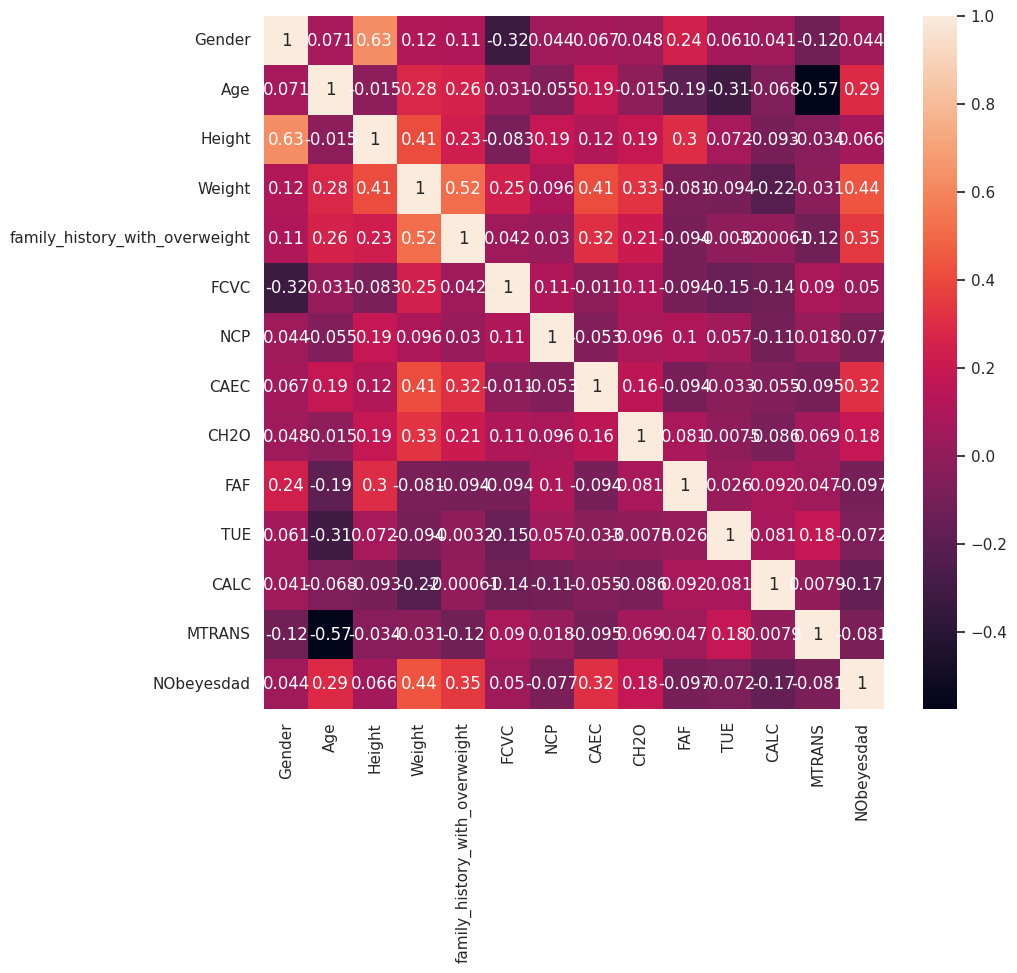

In [39]:
# Everything in our data in converted into numerical data, now lets see the correlation between each of them
sns.heatmap(df1.corr(), annot=True)
plt.gcf().set_size_inches((10,9))

In [40]:
df1["Age"].quantile([0.25, 0.5, 0.75, 0.8, 0.9, 0.95, 0.99])

0.25    20.000000
0.50    22.882558
0.75    26.000000
0.80    26.000000
0.90    31.540751
0.95    36.000000
0.99    41.000000
Name: Age, dtype: float64

In [41]:
# 99% of the data are taken for the ages which are less than or equal to 40
# So hence the upper limit for this particular model is 40
df1 = df1[df1["Age"] <=41]
df1.shape

(19804, 14)

### From the heatmap it seems that the predictor variables are weakly related with the targte variable


In [42]:

df1["BMI"] = df1["Weight"]/df1["Height"]**2
df1.drop(["Weight", "Height"], axis=1, inplace=True)

<ipython-input-42-0eacdfcde60e>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df1["BMI"] = df1["Weight"]/df1["Height"]**2
<ipython-input-42-0eacdfcde60e>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df1.drop(["Weight", "Height"], axis=1, inplace=True)


In [43]:
df1.shape

(19804, 13)

In [44]:
df1.columns

Index(['Gender', 'Age', 'family_history_with_overweight', 'FCVC', 'NCP',
       'CAEC', 'CH2O', 'FAF', 'TUE', 'CALC', 'MTRANS', 'NObeyesdad', 'BMI'],
      dtype='object')

### Theses are the steps that need to follow before we build our model
- Remove outliers
- Split the datatset into train and test
- Scale the values
- Extract best features
- Experiment with differnt Machine Learning models

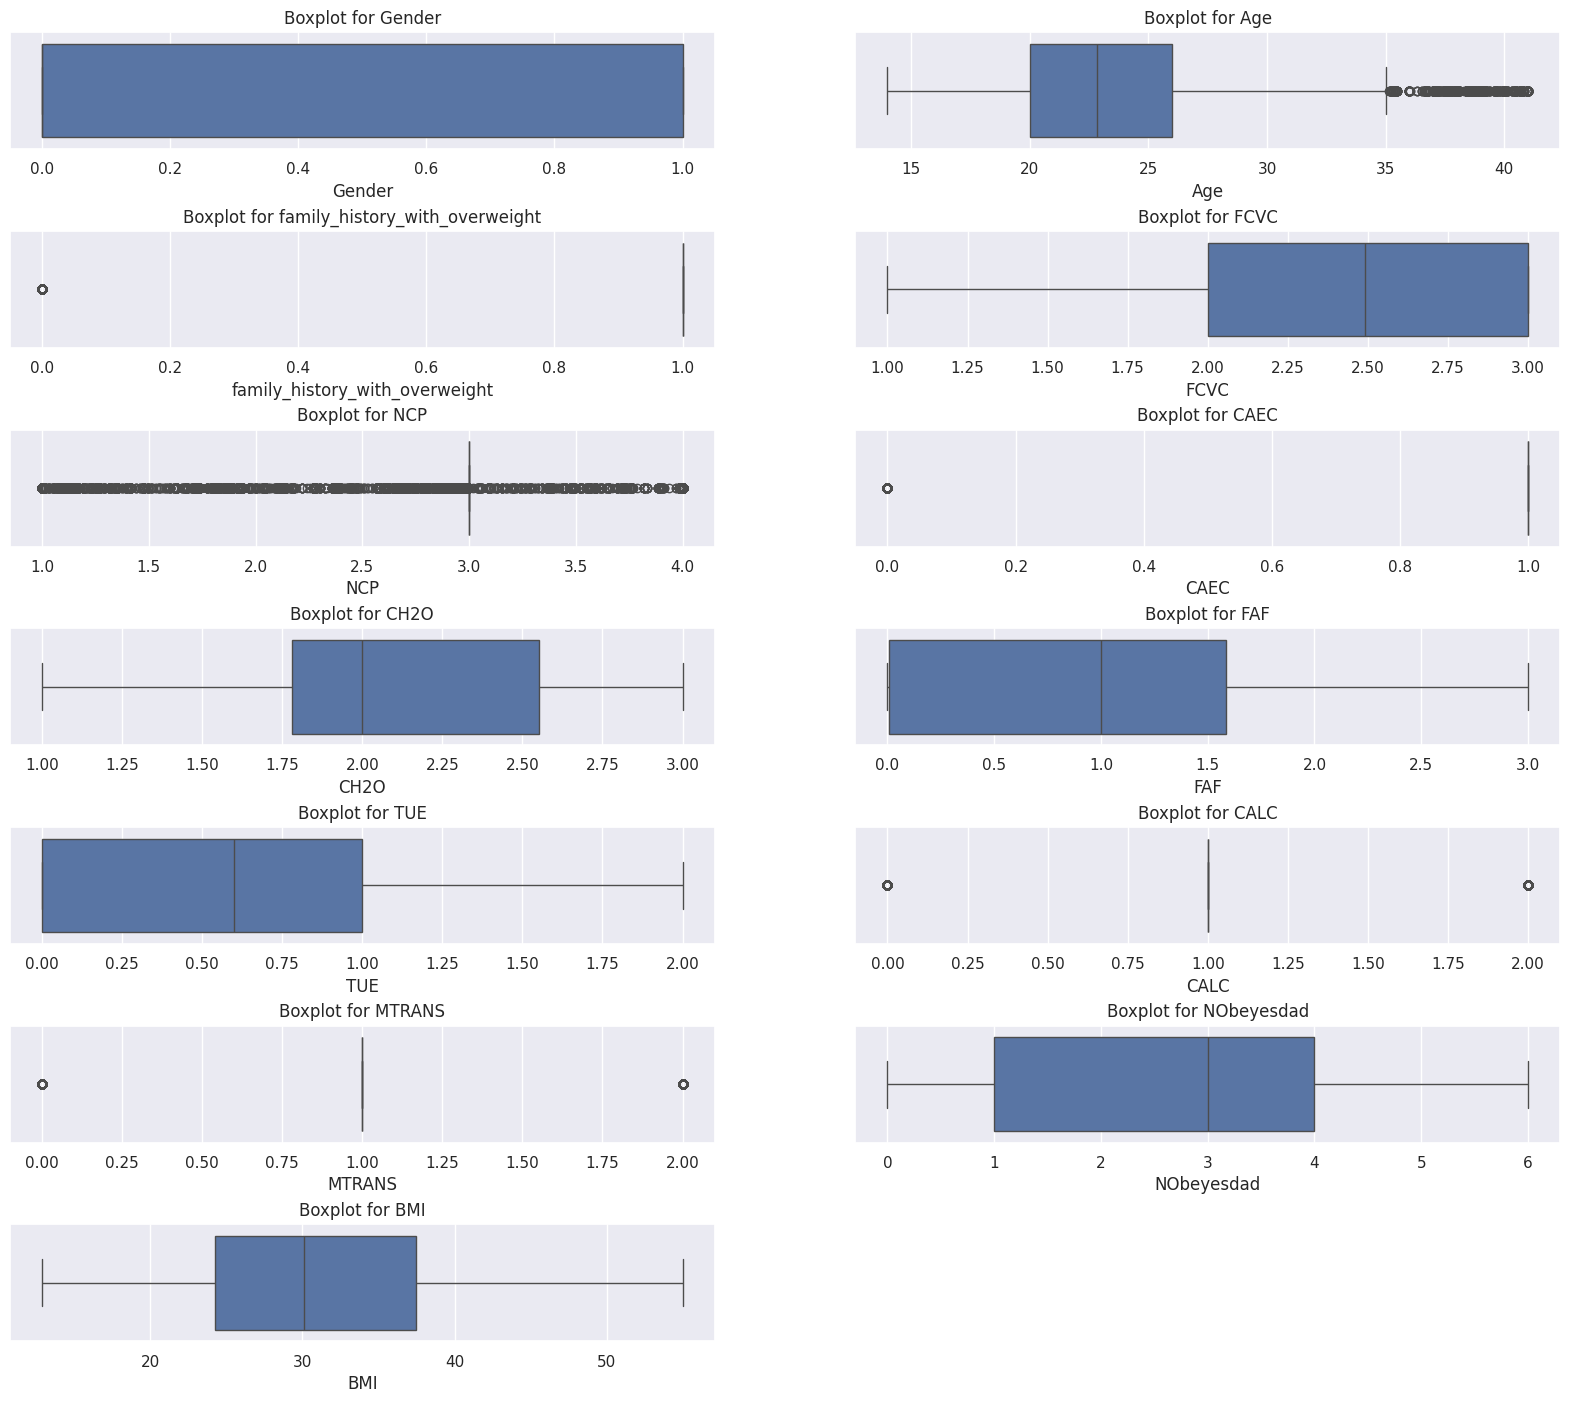

In [45]:
# Outlier removal
for index, column in enumerate(df1.columns):
  plt.subplot(7, 2, index+1)
  sns.boxplot(data=df1, x=column)
  plt.title(f"Boxplot for {column}")
  plt.gcf().set_size_inches((20,17))
  plt.subplots_adjust(hspace=0.7)


### Given the nature of the boxplot we will go with Standard scaler which is invarient to outliers

In [46]:
y = df1.pop("NObeyesdad")
X = df1

In [47]:

# Splitting the dataset into train and test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)


In [48]:
# Resetting the index
X_train = X_train.reset_index().drop("index", axis=1)
X_test = X_test.reset_index().drop("index", axis=1)
y_train = y_train.reset_index().drop("index", axis=1)
y_test = y_test.reset_index().drop("index", axis=1)

In [49]:
y_test

,NObeyesdad
0,3
1,3
2,3
3,3
4,1
...,...
5937,4
5938,0
5939,5
5940,1


In [50]:
# Scaling the values
# Vals to scale = ["Age" ,"BMI"]
scaler = StandardScaler()
X_train_scaled = X_train.copy()
X_test_scaled = X_test.copy()

X_train_scaled[["Age", "BMI"]]= scaler.fit_transform(X_train[["Age", "BMI"]])
X_test_scaled[["Age", "BMI"]] = scaler.transform(X_test[["Age", "BMI"]])

X_train_scaled

,Gender,Age,family_history_with_overweight,FCVC,NCP,CAEC,CH2O,FAF,TUE,CALC,MTRANS,BMI
0,0,0.412999,1,3.000000,3.00000,1,1.000000,0.000000,0.770200,1,1,0.997575
1,1,-0.131554,1,2.000000,3.00000,1,3.000000,0.000000,2.000000,1,1,0.310482
2,1,-0.756109,1,3.000000,3.24934,1,2.425927,1.874662,0.839659,2,0,-1.404008
3,1,-0.900149,1,3.000000,3.00000,1,3.000000,3.000000,1.000000,0,1,-0.496713
4,1,-1.268066,1,2.824559,2.89292,1,2.369627,1.079934,0.174848,1,1,-0.522177
...,...,...,...,...,...,...,...,...,...,...,...,...
13857,0,-0.900149,0,3.000000,3.00000,0,1.000000,1.000000,0.000000,1,1,-1.605140
13858,1,0.343628,1,2.219650,3.00000,1,2.165408,1.315045,1.875683,1,1,0.781898
13859,1,-0.515852,1,2.000000,3.00000,1,2.000000,1.000000,1.000000,1,1,-1.360954
13860,1,-0.530300,1,2.000000,3.00000,1,2.292906,0.027101,0.000000,1,1,0.276105


In [51]:
y_train = y_train.to_numpy().reshape((y_train.shape[0],))
y_test = y_test.to_numpy().reshape((y_test.shape[0],))

In [52]:
y_train.shape[0]

13862

In [53]:
# Since we are dealing with a multiclass problem binary classification models such as logistic regression wont work
# We need only require tree models
classifiers = {"Random Forest": RandomForestClassifier(n_estimators=40),
               "Decision Tree" : DecisionTreeClassifier(),
               "XGboost" : XGBClassifier(n_estimators=40),
               "catboost" : CatBoostClassifier(iterations=100)}

def pipeline(classifiers:Dict, X_train, y_train, X_test, y_test):
  for name, classifier in classifiers.items():
    print(f"Training model based on {name}")
    classifier.fit(X_train, y_train)
    y_train_pred = classifier.predict(X_train)
    y_test_pred = classifier.predict(X_test)
    print(f"\nClassification reports for train data for {name} :\n{classification_report(y_train, y_train_pred)}\n")
    print(f"Classification report for test data for {name} : \n{classification_report(y_test, y_test_pred)}\n")



In [54]:
pipeline(classifiers, X_train, y_train, X_test, y_test)

Training model based on Random Forest

Classification reports for train data for Random Forest :
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      1745
           1       1.00      1.00      1.00      1927
           2       1.00      1.00      1.00      1966
           3       1.00      1.00      1.00      2263
           4       1.00      1.00      1.00      2796
           5       1.00      1.00      1.00      1484
           6       1.00      1.00      1.00      1681

    accuracy                           1.00     13862
   macro avg       1.00      1.00      1.00     13862
weighted avg       1.00      1.00      1.00     13862


Classification report for test data for Random Forest : 
              precision    recall  f1-score   support

           0       0.92      0.92      0.92       733
           1       0.83      0.88      0.85       840
           2       0.86      0.85      0.86       803
           3       0.96      0.

In [55]:
# There is a draw between XGBoost and catboosting, we can go ahead with either of the model
# Let's try k nearest neighbors for classification
knn = KNeighborsClassifier(n_neighbors=7)
knn.fit(X_train_scaled, y_train)
y_train_pred = knn.predict(X_train_scaled)
print(f"Classification report for train data :\n{classification_report(y_train, y_train_pred)}")
y_test_pred = knn.predict(X_test_scaled)
print(f"Classification report for test data :\n{classification_report(y_test, y_test_pred)}")

Classification report for train data :
              precision    recall  f1-score   support

           0       0.86      0.90      0.88      1745
           1       0.75      0.77      0.76      1927
           2       0.79      0.81      0.80      1966
           3       0.92      0.96      0.94      2263
           4       0.99      1.00      1.00      2796
           5       0.68      0.63      0.65      1484
           6       0.74      0.65      0.69      1681

    accuracy                           0.84     13862
   macro avg       0.82      0.82      0.82     13862
weighted avg       0.84      0.84      0.84     13862

Classification report for test data :
              precision    recall  f1-score   support

           0       0.81      0.86      0.84       733
           1       0.65      0.67      0.66       840
           2       0.74      0.77      0.76       803
           3       0.93      0.95      0.94       962
           4       1.00      1.00      1.00      1249
 

### The tree models are doing fine but it is marginally outperformed by K-nearest neighbors

In [56]:
# Let's load the encodings for our target variable
encod

,enc_Gender,act_Gender,enc_family_history_with_overweight,act_family_history_with_overweight,enc_CAEC,act_CAEC,enc_CALC,act_CALC,enc_MTRANS,act_MTRANS,enc_NObeyesdad,act_NObeyesdad
0,1.0,Male,1.0,yes,1.0,Sometimes,1.0,Sometimes,1.0,Public_Transportation,6,Overweight_Level_II
1,0.0,Female,0.0,no,0.0,Frequently,2.0,no,0.0,Automobile,1,Normal_Weight
2,,,,,,,0.0,Frequently,2.0,walk_two_wheelers,0,Insufficient_Weight
3,,,,,,,,,,,4,Obesity_Type_III
4,,,,,,,,,,,3,Obesity_Type_II
5,,,,,,,,,,,5,Overweight_Level_I
6,,,,,,,,,,,2,Obesity_Type_I


In [57]:
preds = pd.DataFrame({"enc_NObeyesdad":y_test_pred})

In [58]:

pd.merge(preds,encod[["enc_NObeyesdad", "act_NObeyesdad"]], on="enc_NObeyesdad", how="left")

,enc_NObeyesdad,act_NObeyesdad
0,3,Obesity_Type_II
1,3,Obesity_Type_II
2,3,Obesity_Type_II
3,3,Obesity_Type_II
4,0,Insufficient_Weight
...,...,...
5937,4,Obesity_Type_III
5938,0,Insufficient_Weight
5939,5,Overweight_Level_I
5940,0,Insufficient_Weight


In [59]:
# We will go ahead with Xgboost
boost = XGBClassifier(n_estimators=40)
boost.fit(X_train, y_train)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=40, n_jobs=None,
              num_parallel_tree=None, objective='multi:softprob', ...)

In [60]:
print(classification_report(y_test, boost.predict(X_test)))

              precision    recall  f1-score   support

           0       0.92      0.93      0.93       733
           1       0.85      0.89      0.87       840
           2       0.87      0.86      0.86       803
           3       0.96      0.95      0.95       962
           4       1.00      1.00      1.00      1249
           5       0.76      0.74      0.75       641
           6       0.77      0.78      0.77       714

    accuracy                           0.89      5942
   macro avg       0.88      0.88      0.88      5942
weighted avg       0.89      0.89      0.89      5942



In [91]:
def save_model(model, name_of_model):
  name_of_model += ".pkl"
  with open(name_of_model, "wb") as file:
    print(f"Saving the model")
    pickle.dump(model, file)


In [92]:
save_model(boost, "xgboost")

Saving the model


In [ ]:
X_test.to_csv("test_file.csv", index=False)

In [62]:
def file_preprocessing(df):
  df = df.drop(["id", "SMOKE", "SCC", "FAVC"], axis=1)
  df = df[~df["CAEC"].isin(["Always", "No"])]
  df["MTRANS"] = df["MTRANS"].replace(["Walking", "Motorbike", "Bike"], "walk_two_wheelers")
  df = df[df["Age"] <= 40]
  df["BMI"] = df["Weight"]/df["Height"]**2
  df = df.drop(["Height", "Weight"], axis=1)
  return df

In [63]:
df1.head()

,Gender,Age,family_history_with_overweight,FCVC,NCP,CAEC,CH2O,FAF,TUE,CALC,MTRANS,BMI
0,1,24.443011,1,2.000000,2.983297,1,2.763573,0.000000,0.976473,1,1,28.259565
1,0,18.000000,1,2.000000,3.000000,0,2.000000,1.000000,1.000000,2,0,23.422091
2,0,18.000000,1,1.880534,1.411685,1,1.910378,0.866045,1.673584,2,1,17.126706
3,0,20.952737,1,3.000000,3.000000,1,1.674061,1.467863,0.780199,1,1,44.855798
4,1,31.641081,1,2.679664,1.971472,1,1.979848,1.967973,0.931721,1,1,25.599151


In [64]:
X_train

,Gender,Age,family_history_with_overweight,FCVC,NCP,CAEC,CH2O,FAF,TUE,CALC,MTRANS,BMI
0,0,25.834018,1,3.000000,3.00000,1,1.000000,0.000000,0.770200,1,1,38.840048
1,1,23.000000,1,2.000000,3.00000,1,3.000000,0.000000,2.000000,1,1,33.057851
2,1,19.749627,1,3.000000,3.24934,1,2.425927,1.874662,0.839659,2,0,18.629649
3,1,19.000000,1,3.000000,3.00000,1,3.000000,3.000000,1.000000,0,1,26.264944
4,1,17.085250,1,2.824559,2.89292,1,2.369627,1.079934,0.174848,1,1,26.050652
...,...,...,...,...,...,...,...,...,...,...,...,...
13857,0,19.000000,0,3.000000,3.00000,0,1.000000,1.000000,0.000000,1,1,16.937032
13858,1,25.472995,1,2.219650,3.00000,1,2.165408,1.315045,1.875683,1,1,37.025033
13859,1,21.000000,1,2.000000,3.00000,1,2.000000,1.000000,1.000000,1,1,18.991965
13860,1,20.924808,1,2.000000,3.00000,1,2.292906,0.027101,0.000000,1,1,32.768554


In [65]:
X_train.columns

Index(['Gender', 'Age', 'family_history_with_overweight', 'FCVC', 'NCP',
       'CAEC', 'CH2O', 'FAF', 'TUE', 'CALC', 'MTRANS', 'BMI'],
      dtype='object')

In [66]:
a = ['Age', 'Gender', 'family_history_with_overweight', 'FCVC', 'NCP',
'CAEC', 'CH2O', 'FAF', 'TUE', 'CALC', 'MTRANS', 'BMI']

X_train.columns[0] in a

True

In [67]:
 boost.predict(X_test)

array([3, 3, 3, ..., 5, 1, 4])

In [68]:
a = pd.DataFrame({"enc_NObeyesdad" : boost.predict(X_test)})

In [70]:
# Forming a proper df
output = pd.DataFrame({"enc_NObeyesdad":boost.predict(X_test)})
output

,enc_NObeyesdad
0,3
1,3
2,3
3,3
4,1
...,...
5937,4
5938,0
5939,5
5940,1


In [71]:
temp_test = X_test.copy()
temp_test.head()

,Gender,Age,family_history_with_overweight,FCVC,NCP,CAEC,CH2O,FAF,TUE,CALC,MTRANS,BMI
0,1,25.957740,1,1.264234,3.0,1,2.020313,1.596576,0.002600,1,1,36.649403
1,1,26.844812,1,2.111887,3.0,1,1.959531,1.281165,1.229474,1,1,34.457358
2,1,32.593129,1,2.000000,3.0,1,1.000000,1.946907,0.000000,2,1,35.800392
3,1,28.770852,1,2.442536,3.0,1,2.000000,1.976341,0.000000,1,1,35.954007
4,0,28.000000,1,2.000000,3.0,0,1.000000,1.000000,0.000000,2,1,18.612245


In [79]:
output.merge(encodings, on="enc_NObeyesdad", how="left")

,enc_NObeyesdad,act_NObeyesdad
0,3,Obesity_Type_II
1,3,Obesity_Type_II
2,3,Obesity_Type_II
3,3,Obesity_Type_II
4,1,Normal_Weight
...,...,...
5937,4,Obesity_Type_III
5938,0,Insufficient_Weight
5939,5,Overweight_Level_I
5940,1,Normal_Weight


In [83]:
final_df = pd.concat([temp_test, output.merge(encodings, on="enc_NObeyesdad", how="left")], axis=1)

In [90]:
final_df = final_df.rename(columns={"enc_NObeyesdad":"status_encoding", "act_NObeyesdad":"status"})
final_df

,Gender,Age,family_history_with_overweight,FCVC,NCP,CAEC,CH2O,FAF,TUE,CALC,MTRANS,BMI,status_encoding,status
0,1,25.957740,1,1.264234,3.000000,1,2.020313,1.596576,0.002600,1,1,36.649403,3,Obesity_Type_II
1,1,26.844812,1,2.111887,3.000000,1,1.959531,1.281165,1.229474,1,1,34.457358,3,Obesity_Type_II
2,1,32.593129,1,2.000000,3.000000,1,1.000000,1.946907,0.000000,2,1,35.800392,3,Obesity_Type_II
3,1,28.770852,1,2.442536,3.000000,1,2.000000,1.976341,0.000000,1,1,35.954007,3,Obesity_Type_II
4,0,28.000000,1,2.000000,3.000000,0,1.000000,1.000000,0.000000,2,1,18.612245,1,Normal_Weight
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5937,0,25.954995,1,3.000000,3.000000,1,1.484938,0.072117,0.925843,1,1,33.795464,4,Obesity_Type_III
5938,1,18.000000,1,3.000000,3.000000,0,2.000000,1.000000,1.000000,2,1,17.505615,0,Insufficient_Weight
5939,0,19.515324,0,2.000000,2.893778,1,1.277636,0.614959,0.635867,1,1,28.289924,5,Overweight_Level_I
5940,0,19.000000,1,2.000000,4.000000,1,3.000000,2.000000,2.000000,1,1,20.639636,1,Normal_Weight


In [89]:
encod.to_csv("full_encodings.csv", index=False)

In [69]:
encodings = encod[["enc_NObeyesdad", "act_NObeyesdad"]]

In [78]:
encodings

,enc_NObeyesdad,act_NObeyesdad
0,6,Overweight_Level_II
1,1,Normal_Weight
2,0,Insufficient_Weight
3,4,Obesity_Type_III
4,3,Obesity_Type_II
5,5,Overweight_Level_I
6,2,Obesity_Type_I


In [ ]:
encodings.to_csv("encodings.csv", index=False)

In [ ]:
pd.merge(a, encodings, on="enc_NObeyesdad", how="left")

,enc_NObeyesdad,act_NObeyesdad
0,3,Obesity_Type_II
1,3,Obesity_Type_II
2,3,Obesity_Type_II
3,3,Obesity_Type_II
4,1,Normal_Weight
...,...,...
5937,4,Obesity_Type_III
5938,0,Insufficient_Weight
5939,5,Overweight_Level_I
5940,1,Normal_Weight
